In [1]:
#importing libraries
library(ggplot2)
library(GGally)
library(palmerpenguins)
library(dplyr)
library(caret)
library(psre)
library(splines)
library("scatterplot3d")
library("plot3D")

data(package = 'palmerpenguins')
set.seed(0)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice



Package,Item,Title
<chr>,<chr>,<chr>
palmerpenguins,penguins,"Size measurements for adult foraging penguins near Palmer Station, Antarctica"
palmerpenguins,penguins_raw (penguins),"Penguin size, clutch, and blood isotope data for foraging adults near Palmer Station, Antarctica"


In [2]:
#renaming columns
colnames(penguins) <- c('Species','Island','Bill.Length','Bill.Depth','Flipper.Length','Body.Mass','Sex','Year')
#function to pass to ggplot to control figure size

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(14,10)

In [3]:
#checking for NA
sum(is.na(penguins))
#removing NA
penguins.cleaned <- na.omit(penguins) 

[1] 19

## Question 1
### 1.1 Pairwise Plots
Based on the plots, there is a strong correlation between flipper length and two other variables in the model. Also, observe that correlation of the features is different from the correlation of the features split into species. There are cases where a the correlation of features is a very negative number like with flipper lengh and bill depth. However, all of the correlations by species are positive. Furthermore, there was of an obvious trend of the Gentoo species having higher correlations with their features vs the relatively low correlations of the Adeilie species. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


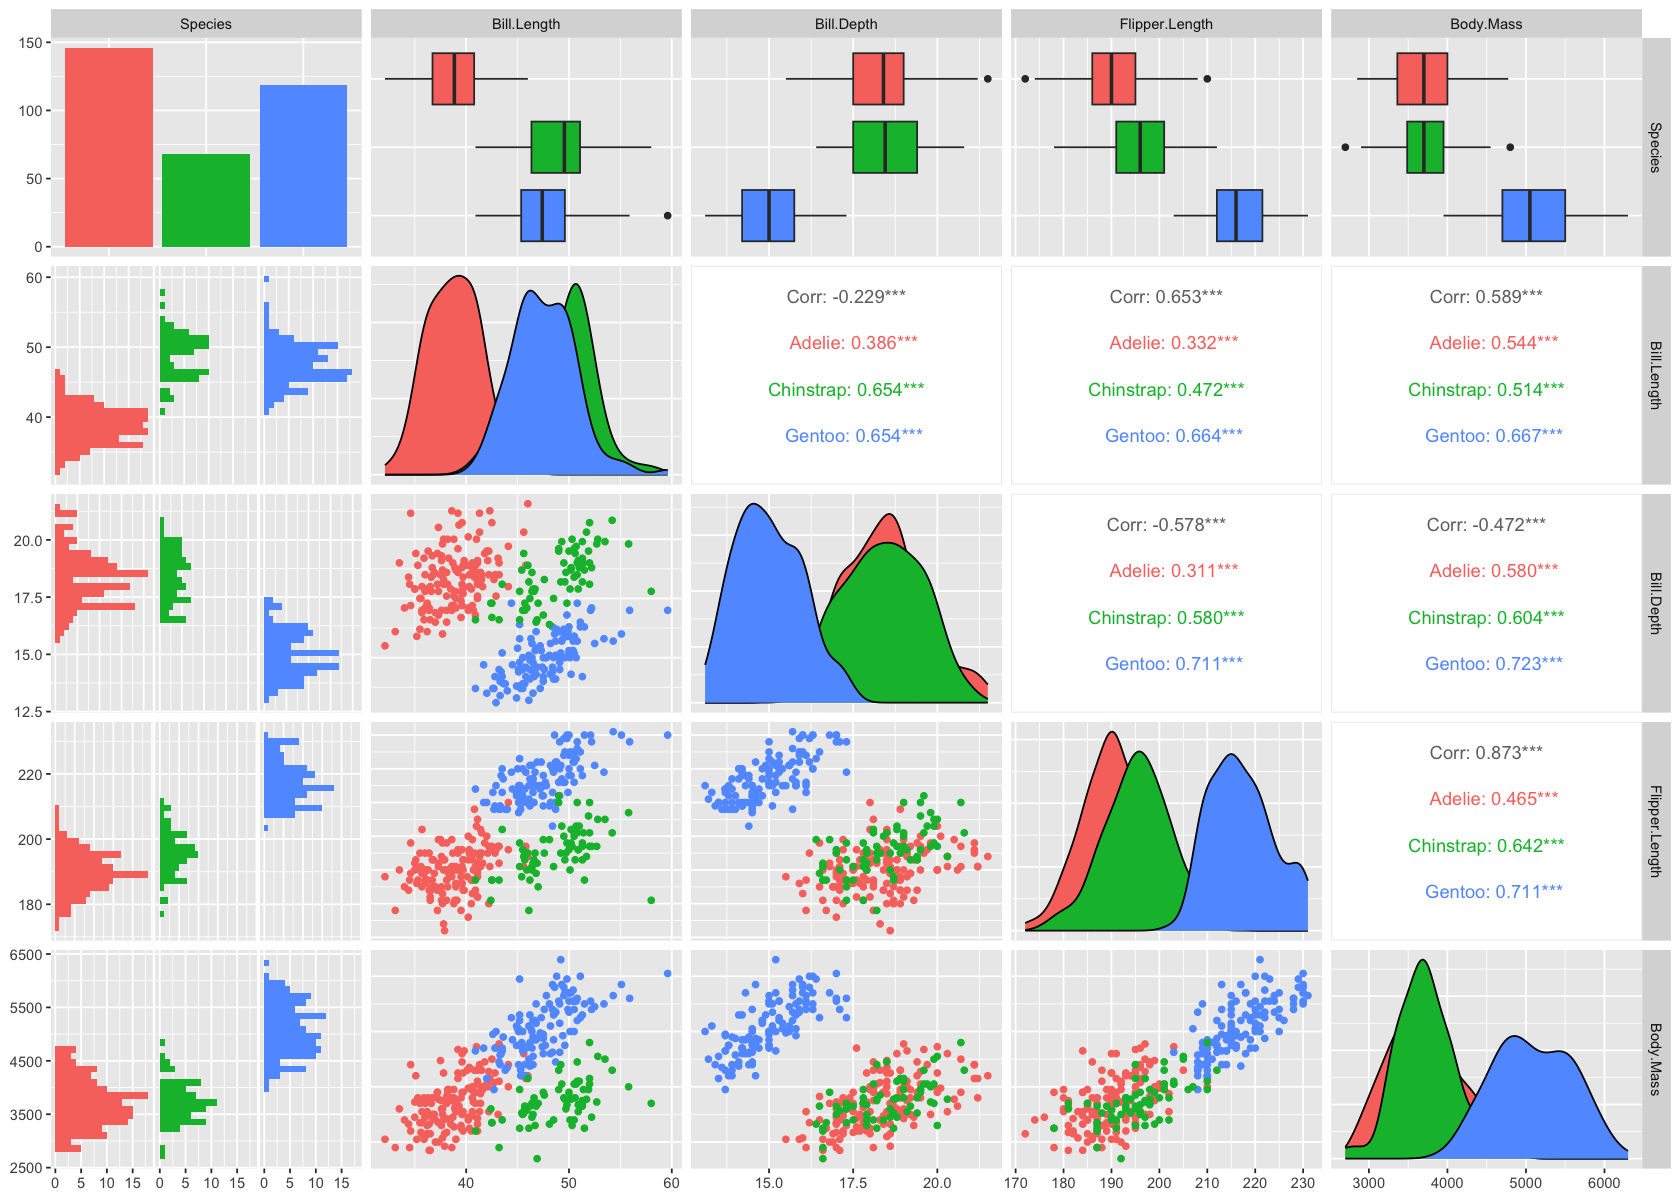

In [4]:
temp <- penguins.cleaned[c('Species','Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')]
ggpairs(temp, mapping = aes(colour = Species))

## Question 1.2 - Calculating Covariance of Dataset and its eigenvalues

In [5]:
#scaling variables
penguins.scaled <- penguins.cleaned %>% mutate(across(where(is.numeric), scale))
#calculating covariance matrix
penguin.cov <- cov(penguins.scaled[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')])
#calculating eigenvalues for covariance matrix
Eigen <- eigen(penguin.cov)
Eigen

eigen() decomposition
$values
[1] 2.7453557 0.7781172 0.3686425 0.1078846

$vectors
           [,1]        [,2]       [,3]       [,4]
[1,]  0.4537532 -0.60019490  0.6424951  0.1451695
[2,] -0.3990472 -0.79616951 -0.4258004 -0.1599044
[3,]  0.5768250 -0.00578817 -0.2360952 -0.7819837
[4,]  0.5496747 -0.07646366 -0.5917374  0.5846861


## Question 1.3 - Calculating PCA of Dataset
The loadings for each variable are approximately the same as the eigenvector for each variable. This is because, the eigen vectors of the covariance matrix returns the direction attributed by each variable and eigenvalues that gives the variance of a variable in that respective direction. This is at the core of how PCA works.
Thus the eigenvector with largest value (the eigenvector with the largest variation) is the first component of the PCA. Similarly, the second principle component the 2nd largest eigenvector and so forth.

In [6]:
#calculating principle components
k <- (princomp(penguins.scaled[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')]))
k$loadings


Loadings:
               Comp.1 Comp.2 Comp.3 Comp.4
Bill.Length     0.454  0.600  0.642  0.145
Bill.Depth     -0.399  0.796 -0.426 -0.160
Flipper.Length  0.577        -0.236 -0.782
Body.Mass       0.550        -0.592  0.585

               Comp.1 Comp.2 Comp.3 Comp.4
SS loadings      1.00   1.00   1.00   1.00
Proportion Var   0.25   0.25   0.25   0.25
Cumulative Var   0.25   0.50   0.75   1.00

## Question 1.4 PCA for each species
I noticed that moving from Adelie, to Chinstrap to Gentoo, the first principle component (Bill Length) explains more of the variance. For example, the 1st PCA for Adelie only explians 61% of the variance, but for Chinstrap, it explains 68% of the variance. Similarly, for Gentoo penguins, the first PCA explains more than 3/4 of the variance (77%) in the sample. 

In [7]:
#grouping rows by species and assigning to new variable
penguin.grpd <- penguins.scaled %>% 
group_by(Species)

#### PCA for Adelie

In [8]:
#filtering penguins by species
adelie <- filter(penguin.grpd, Species == 'Adelie')
#performs pca on selected variables
summary(princomp(adelie[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')]))

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4
Standard deviation     0.8361638 0.4440626 0.3862577 0.32843231
Proportion of Variance 0.6061689 0.1709619 0.1293496 0.09351961
Cumulative Proportion  0.6061689 0.7771308 0.9064804 1.00000000

#### PCA for Chinstrap

In [9]:
#filtering penguins by species
chinstrap <- filter(penguin.grpd, Species == 'Chinstrap')
#performs pca on selected variables
summary(princomp(chinstrap[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')]))

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4
Standard deviation     0.8991543 0.4188826 0.32617115 0.29012126
Proportion of Variance 0.6883603 0.1493936 0.09058127 0.07166489
Cumulative Proportion  0.6883603 0.8377538 0.92833511 1.00000000

#### PCA for Gentoo

In [10]:
#filtering penguins by species
Gentoo <- filter(penguin.grpd, Species == 'Gentoo')
#performs pca on selected variables
summary(princomp(Gentoo[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')]))#$loadings

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4
Standard deviation     0.9497572 0.3429128 0.29253838 0.25845017
Proportion of Variance 0.7696556 0.1003318 0.07301918 0.05699344
Cumulative Proportion  0.7696556 0.8699874 0.94300656 1.00000000

## Question 1.5 (Ask because I expected by PCA to perform better)
Based on this regression, the vanilla regression model performs better will all of the variables versus the model using the first two principal components. This is expected because using only the first two principal components, only approximately 85% of the data is explained. Using the 3rd PCA, 97% of the variance would be explained. However, the model with the PCA's did not perform drastically worse than the vanilla model. The latter had an accuracy of 88% , while the prior had an accuracy score of 76%

In [11]:

#splitting data
train <-sample_frac(penguins.scaled,300/333)

train_index <- as.numeric(rownames(train))

test <- penguins.scaled[-train_index, ]

summary(princomp(penguins.scaled[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')]))

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4
Standard deviation     1.6544218 0.8807840 0.60624705 0.32796434
Proportion of Variance 0.6863389 0.1945293 0.09216063 0.02697115
Cumulative Proportion  0.6863389 0.8808682 0.97302885 1.00000000

### Logistic Regression with Bill Length, Bill Depth, Flipper Length and Body Mass

In [12]:
#regression with full stack

#training model 
penguin.fit <- glm(Sex ~ Bill.Length+Bill.Depth+Flipper.Length+Body.Mass,
                   data = train, family = binomial)

#creating predictions to test model
pred_penguin = ifelse(predict(penguin.fit, newdata = test, type= "response") > 0.5, "male", "female")

In [13]:
#calculationg confusion matrix for model
confusionMatrix(as.factor(pred_penguin), as.factor(test$Sex))

Confusion Matrix and Statistics

          Reference
Prediction female male
    female     14    1
    male        3   15
                                        
               Accuracy : 0.8788        
                 95% CI : (0.718, 0.966)
    No Information Rate : 0.5152        
    P-Value [Acc > NIR] : 1.158e-05     
                                        
                  Kappa : 0.7582        
                                        
 Mcnemar's Test P-Value : 0.6171        
                                        
            Sensitivity : 0.8235        
            Specificity : 0.9375        
         Pos Pred Value : 0.9333        
         Neg Pred Value : 0.8333        
             Prevalence : 0.5152        
         Detection Rate : 0.4242        
   Detection Prevalence : 0.4545        
      Balanced Accuracy : 0.8805        
                                        
       'Positive' Class : female        
                                        

### Logistic Regression with First two PCA's

In [14]:
pca_train <- princomp(train[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')])
train$pca.one <- pca_train$scores[,1]
train$pca.two <- pca_train$scores[,2]
#train$pca.tree <- pca_train$scores[,3]

pca_test <- princomp(test[c('Bill.Length','Bill.Depth','Flipper.Length','Body.Mass')])
test$pca.one <- pca_test$scores[,1]
test$pca.two <- pca_test$scores[,2]
#test$pca.tree <- pca_test$scores[,3]

#training model 
penguin.fit_pca <- penguin.fit_pca <- glm(Sex ~ pca.one + pca.two, data = train,
                                          family = binomial)

#creating predictions to test model
pred_penguin_pca = ifelse(predict(penguin.fit_pca, newdata = test, type= "response") > 0.5, "male", "female")

summary(pca_test)

Importance of components:
                          Comp.1    Comp.2     Comp.3    Comp.4
Standard deviation     0.9116950 0.3915844 0.30250690 0.2657374
Proportion of Variance 0.7248817 0.1337269 0.07980655 0.0615848
Cumulative Proportion  0.7248817 0.8586086 0.93841520 1.0000000

In [15]:
#calculationg confusion matrix for model
confusionMatrix(as.factor(pred_penguin_pca), as.factor(test$Sex))

Confusion Matrix and Statistics

          Reference
Prediction female male
    female     12    3
    male        5   13
                                          
               Accuracy : 0.7576          
                 95% CI : (0.5774, 0.8891)
    No Information Rate : 0.5152          
    P-Value [Acc > NIR] : 0.003843        
                                          
                  Kappa : 0.5165          
                                          
 Mcnemar's Test P-Value : 0.723674        
                                          
            Sensitivity : 0.7059          
            Specificity : 0.8125          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.7222          
             Prevalence : 0.5152          
         Detection Rate : 0.3636          
   Detection Prevalence : 0.4545          
      Balanced Accuracy : 0.7592          
                                          
       'Positive' Class : female          
                  

## Question 2

In [16]:
#loading data
data <- read.csv('simulated_data.csv')

### 2.1 Truncated Power Basis Function

In [17]:
#creating truncated power basis function with ONE know placed at x = 1.5
TPB.X1 <- tpb(data$x1, nknots=1, knot_loc = 1.5)

### Question 2.2 - PCA of data points x2 to x5

In [18]:
#first part of code computes pca of desired columns while the second part just outputs the first 3 PCA's
PCA.X2toX5 <- princomp(data[,4:7])$scores[,1:3]
colnames(PCA.X2toX5) <- c('pca1','pca2','pca3')

### Question 2.3 - 4th Order Polynomial for x6

In [19]:
x6.poly <- poly(data$x6,4)
colnames(x6.poly) <- c('poly1','poly2','poly3','poly4')

### Question 2.4 - Natural Cubic Spline for x7

In [20]:
ns.x7 <- ns(data$x7, df = 5)
colnames(ns.x7) <- c('spline1','spline2','spline3','spline4','spline5')

### Question 2.5 - Putting it all together and fitting a model

From this regression, a high adjusted R squared is obtained, 93.77, implying that the predictors explain more than 90% of the variance in the response variable. Similarly, the RMSE was calculated on the test set and is very low, 31.5619, only 1.2799% higher than the RMSE for the training set. In regards to the coefficients, all of the truncated power basis terms had near neglible impact on the predictor as well the second and third PCA for x2 to x5. 

In [21]:
#storing results in a list, then converting to a dataframe)
#i choose this method because it was difficult to convert each datatype to the same form while retaining it's structe
#combining them as a list retained the order and structure and converting it to a dataframe transformed it to a wider format

results <- as.data.frame(list(TPB.X1, PCA.X2toX5, x6.poly, ns.x7))
results$y <- data$y


#splitting data
train <-sample_frac(results,0.7)

train_index <- as.numeric(rownames(train))

test <- results[-train_index, ]

#training model
model.fit <- lm(y~., data=train)
summary(model.fit)
RMSE(model.fit$fitted.values,train$y)

#testing model on validation set

fit.pred <- predict(model.fit,newdata=test)

#calculating RMSE
RMSE(fit.pred,test$y)


Call:
lm(formula = y ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-79.102 -22.015  -1.311  21.579  91.761 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   58.1907    12.3062   4.729 3.34e-06 ***
tpb1          59.7907    37.4750   1.595 0.111553    
tpb2         -61.4813    39.6663  -1.550 0.122100    
tpb3          19.4963    12.0643   1.616 0.107033    
tpb4           1.1529    22.8380   0.050 0.959769    
pca1           9.5482     0.1577  60.532  < 2e-16 ***
pca2          -2.3369     1.3808  -1.692 0.091490 .  
pca3         -12.3027     3.6212  -3.397 0.000763 ***
poly1       -286.1249    40.0176  -7.150 5.53e-12 ***
poly2       -148.7214    39.9870  -3.719 0.000234 ***
poly3        -76.1035    40.2263  -1.892 0.059374 .  
poly4        -17.5863    38.9661  -0.451 0.652051    
spline1       47.3317     9.9624   4.751 3.01e-06 ***
spline2      124.7752    12.8905   9.680  < 2e-16 ***
spline3       54.6187    10.0016   5.461

[1] 32.09907

[1] 31.83791

### Question 2.6
The model is linear because by defintion, a model is linear if it has a linear term summed with polynomial terms. However, the features are non-linear in this model. Moreover, below are plots of the residuals from this model to support the claim. From the first plot we see linearlity approximately holds well and there is no apparent significant pattern. Also the second plot shows quantiles plotted against each other and they, approximately fall in line with each other.  

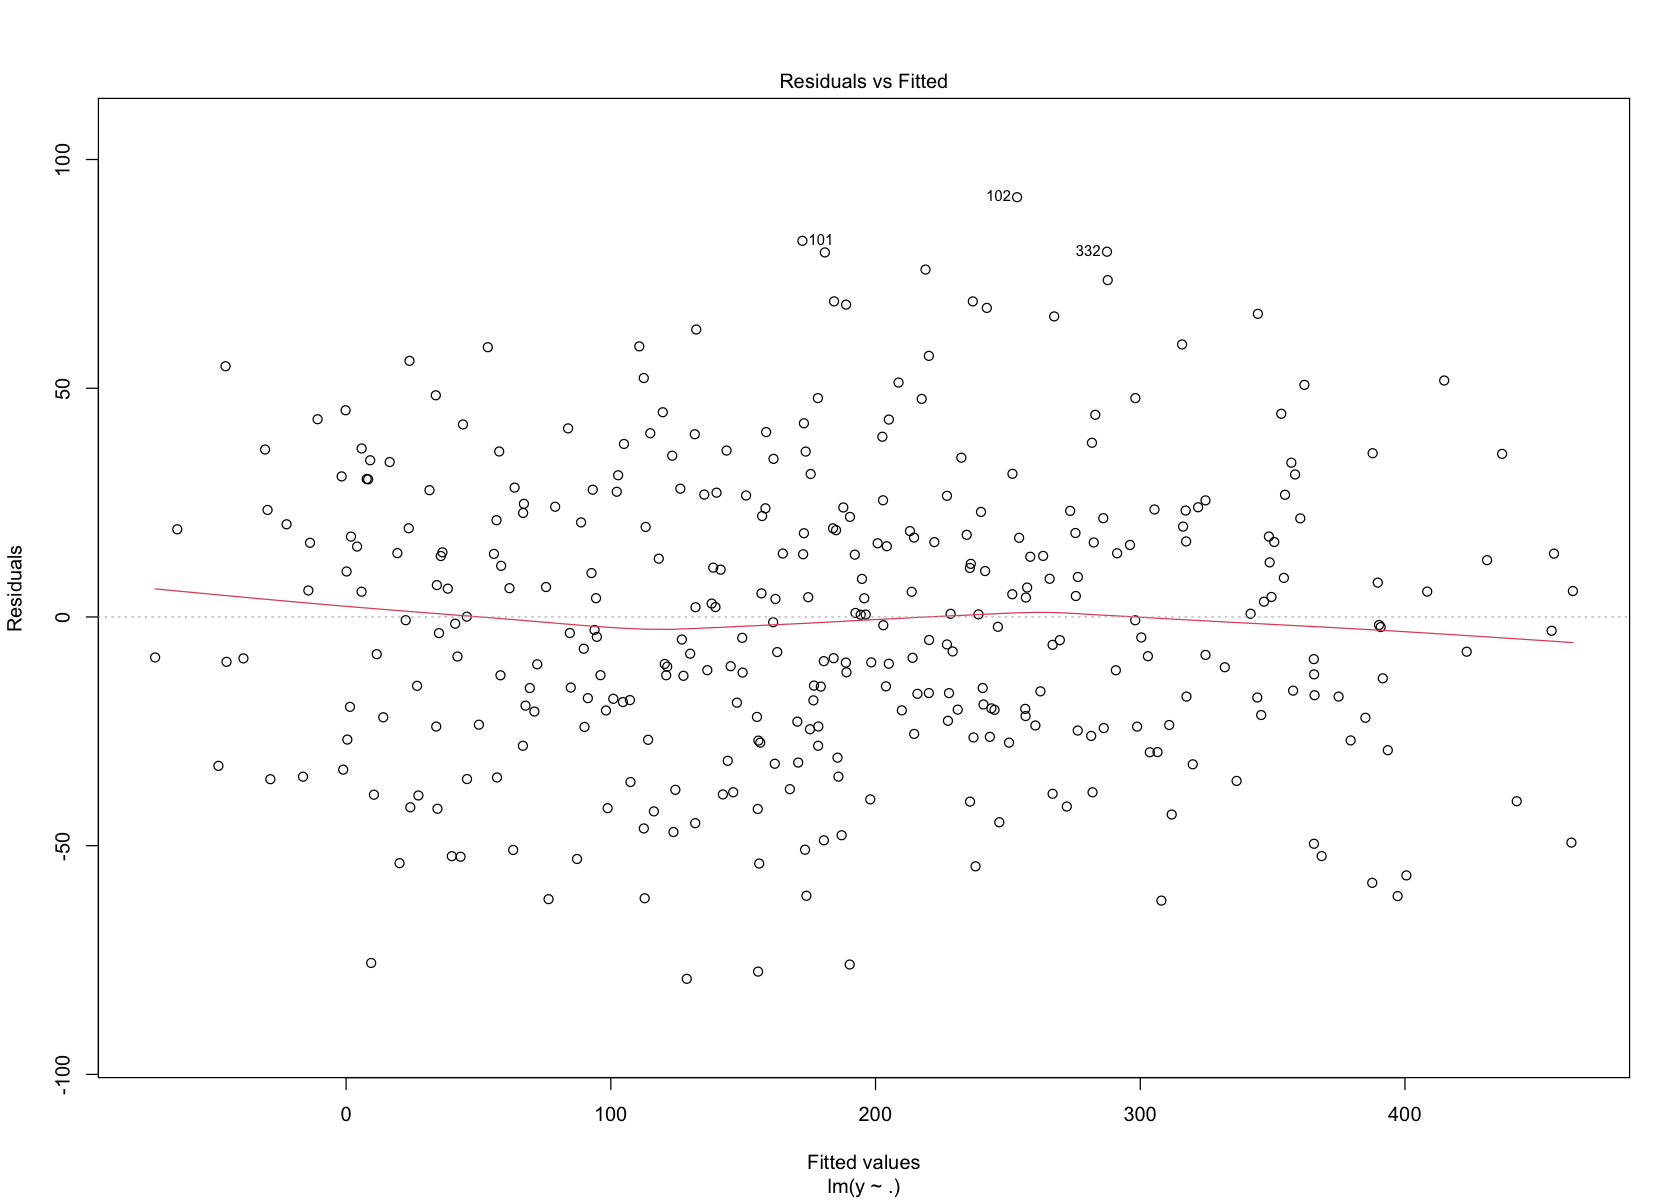

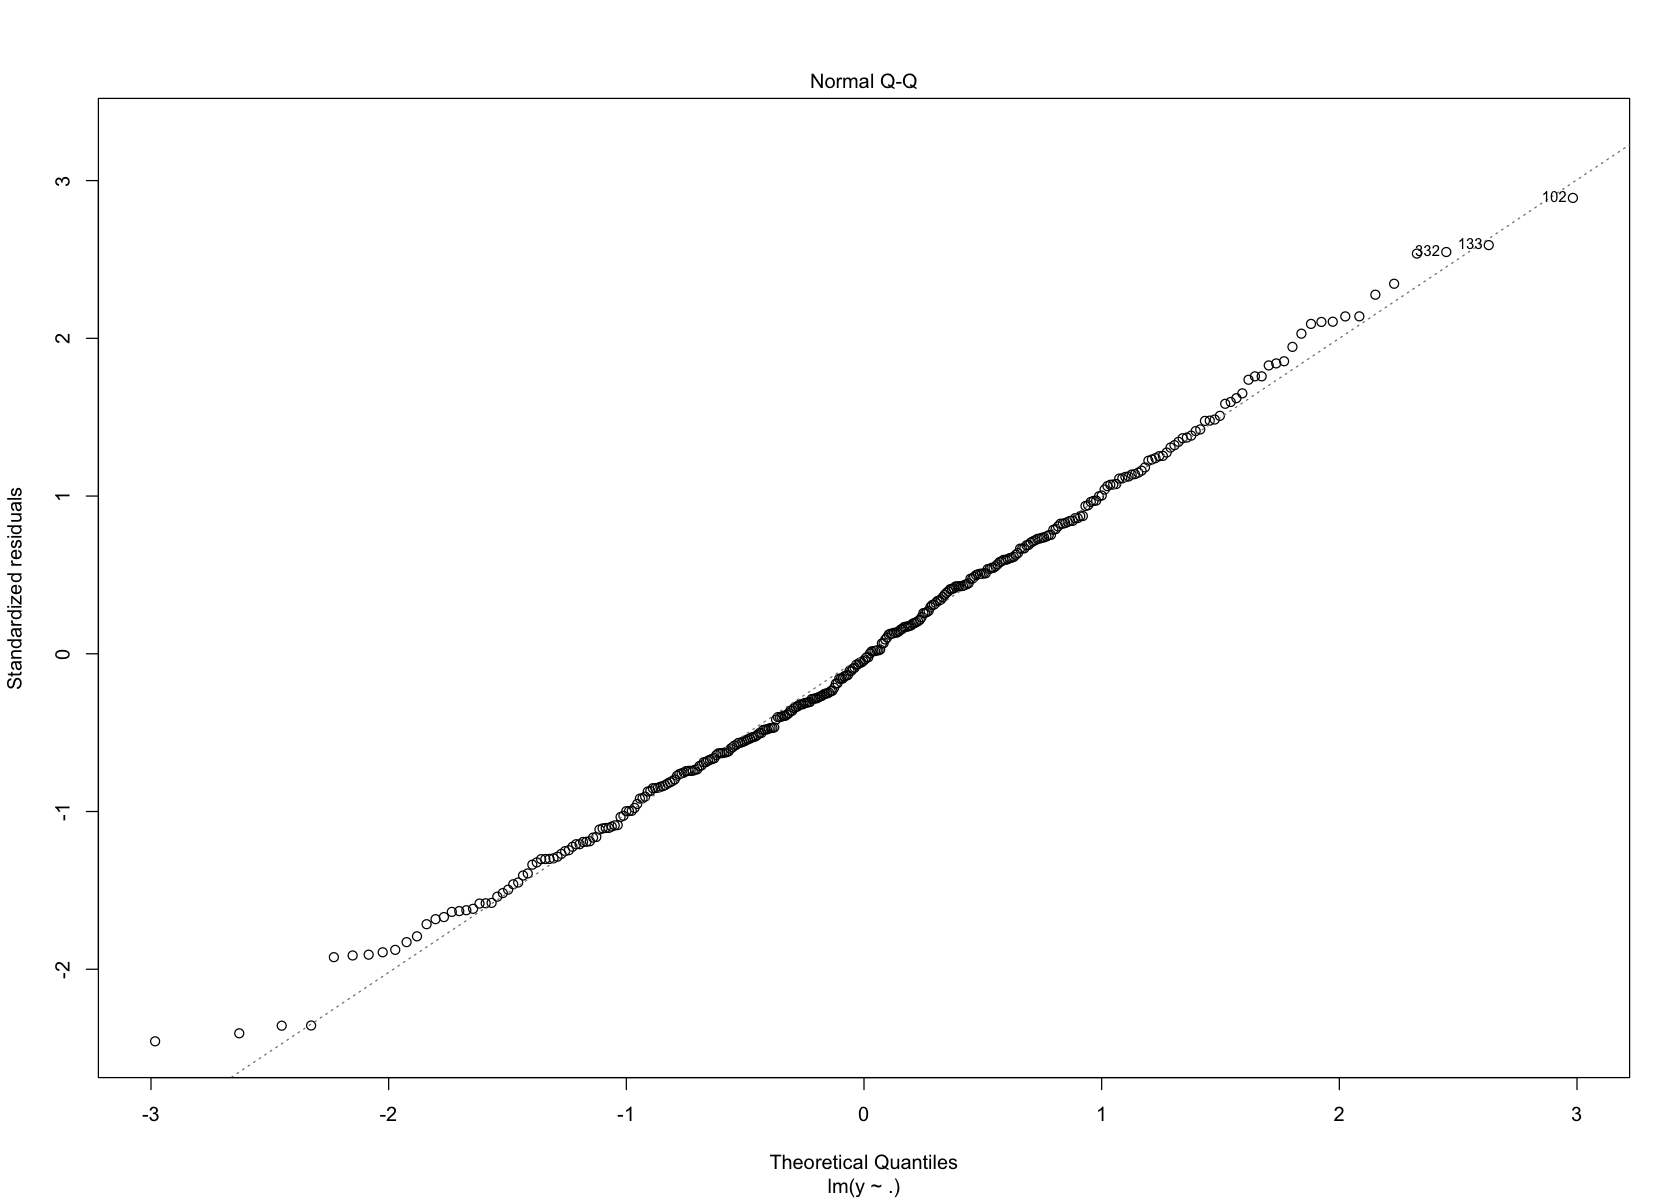

In [22]:
plot(model.fit,1:2)

### Question 2.7 Feature Selection ?
LASSO or Ridge Regression would be not be appropriate because, by definition, they penalize overfitting and multi-colinearity. Using a L1 or L2 norm may be redundant since both methods will push the polynomial terms to 0 because of their correlation with the linear terms and the overfitting is chronic in polynomial regression. AIC method might be more conducive to a researches needs

### Question 2.8 Backfitting vs Least Squares
This method is not appropriate for splitting splines because call the equation, 
$$\text{RSS = } \Sigma_{i=1}^{n} (y_i - g(x_i))^2$$
is what is being minimized by least squares. However, this function can be minimized by setting the function g to 0. This would result in extreme overfitting. However, the backfitting method is not minimizing the RSS, but the residuals themselves i.e. it finds coefficients $B_i$ for i = 1, . . . ,n to minimize $\hat{y}-B_i x_i =  B_0 + B_k x_k$, where $k\neq i$. 

## Question 3 - Polynomial Fits

In [23]:
#checking for NA
sum(is.na(mtcars))
#no NAs to remove

[1] 0

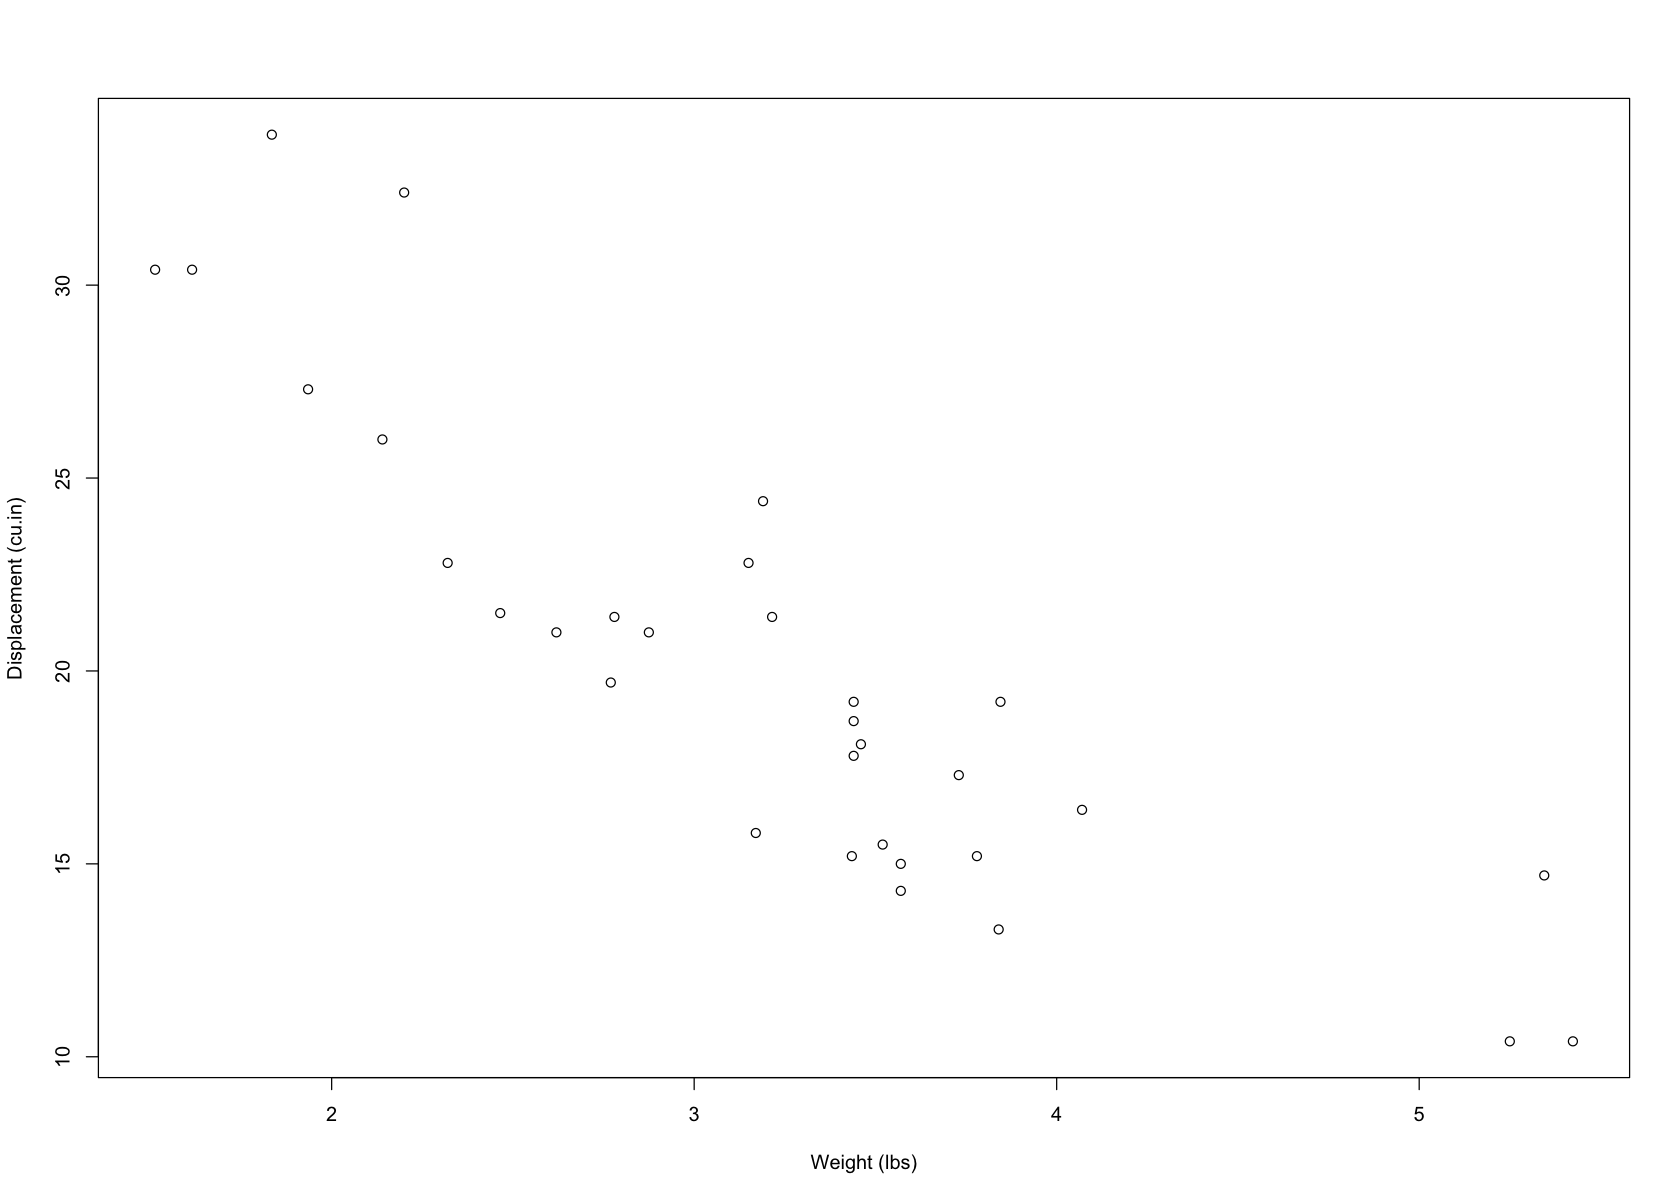

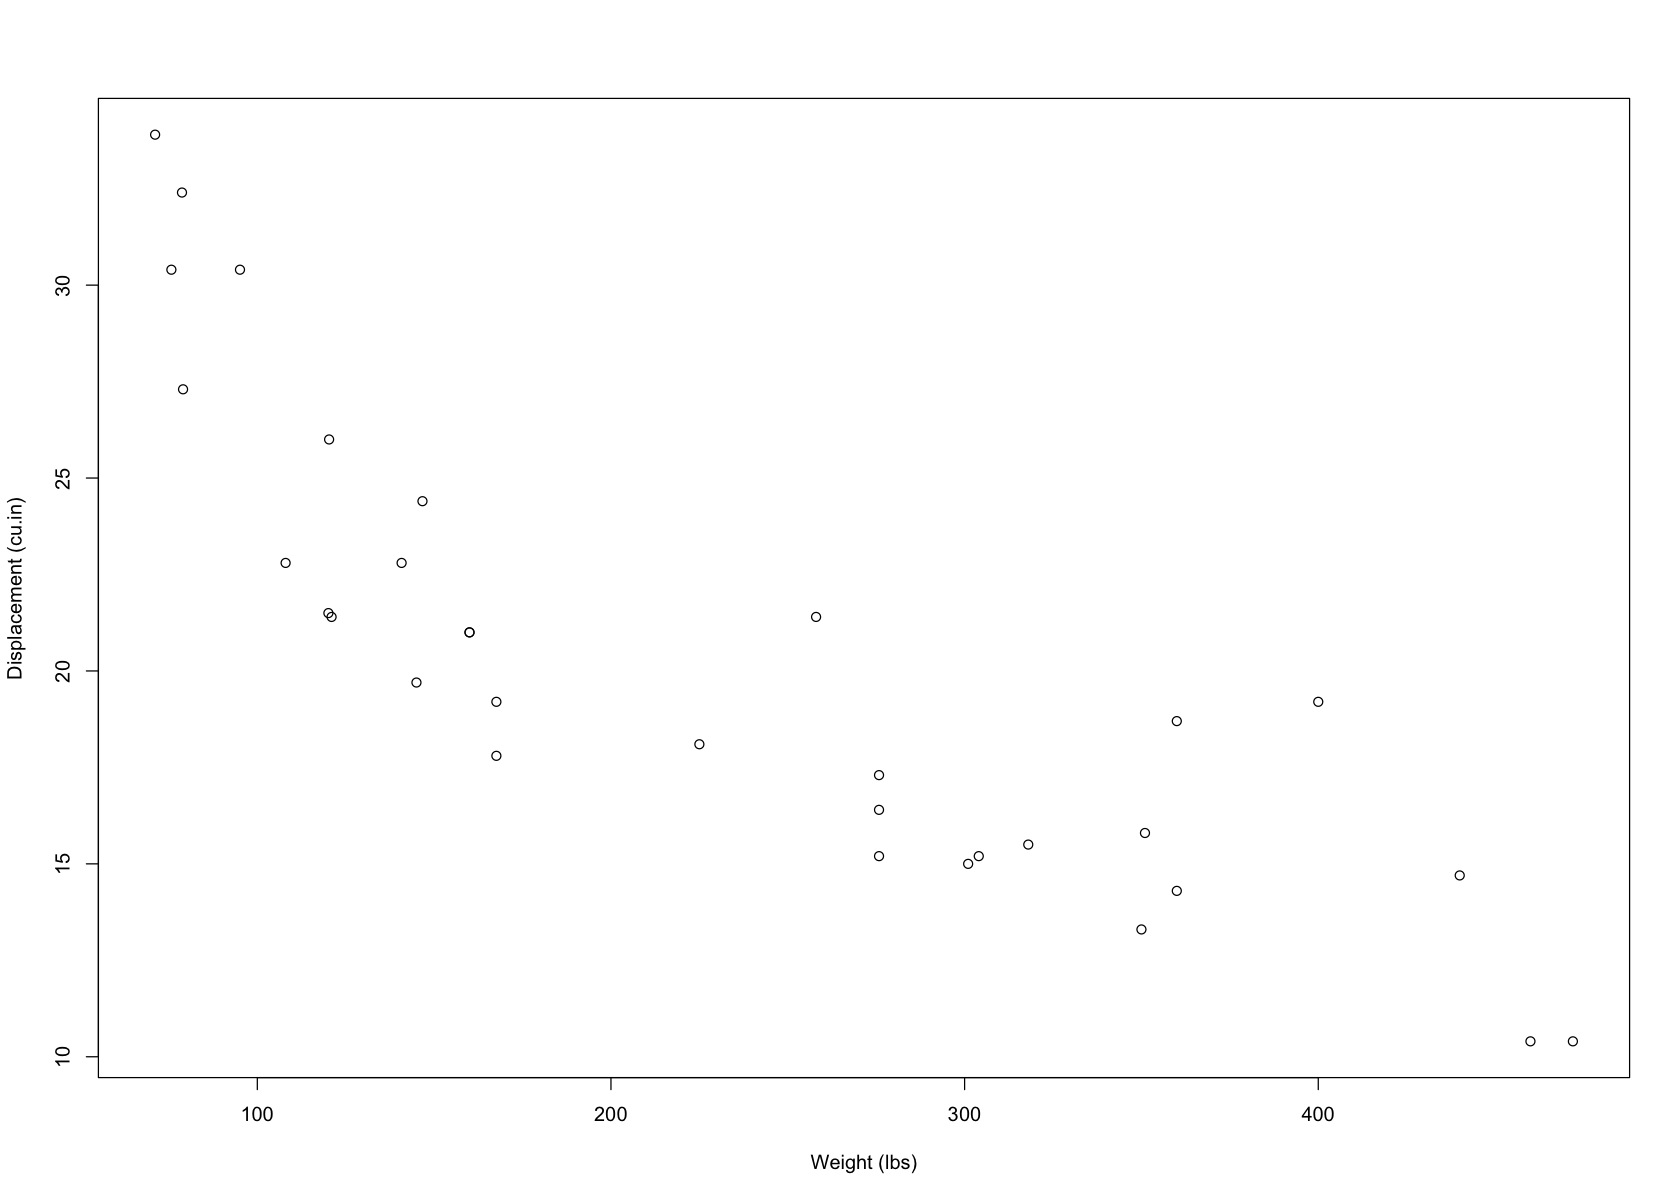

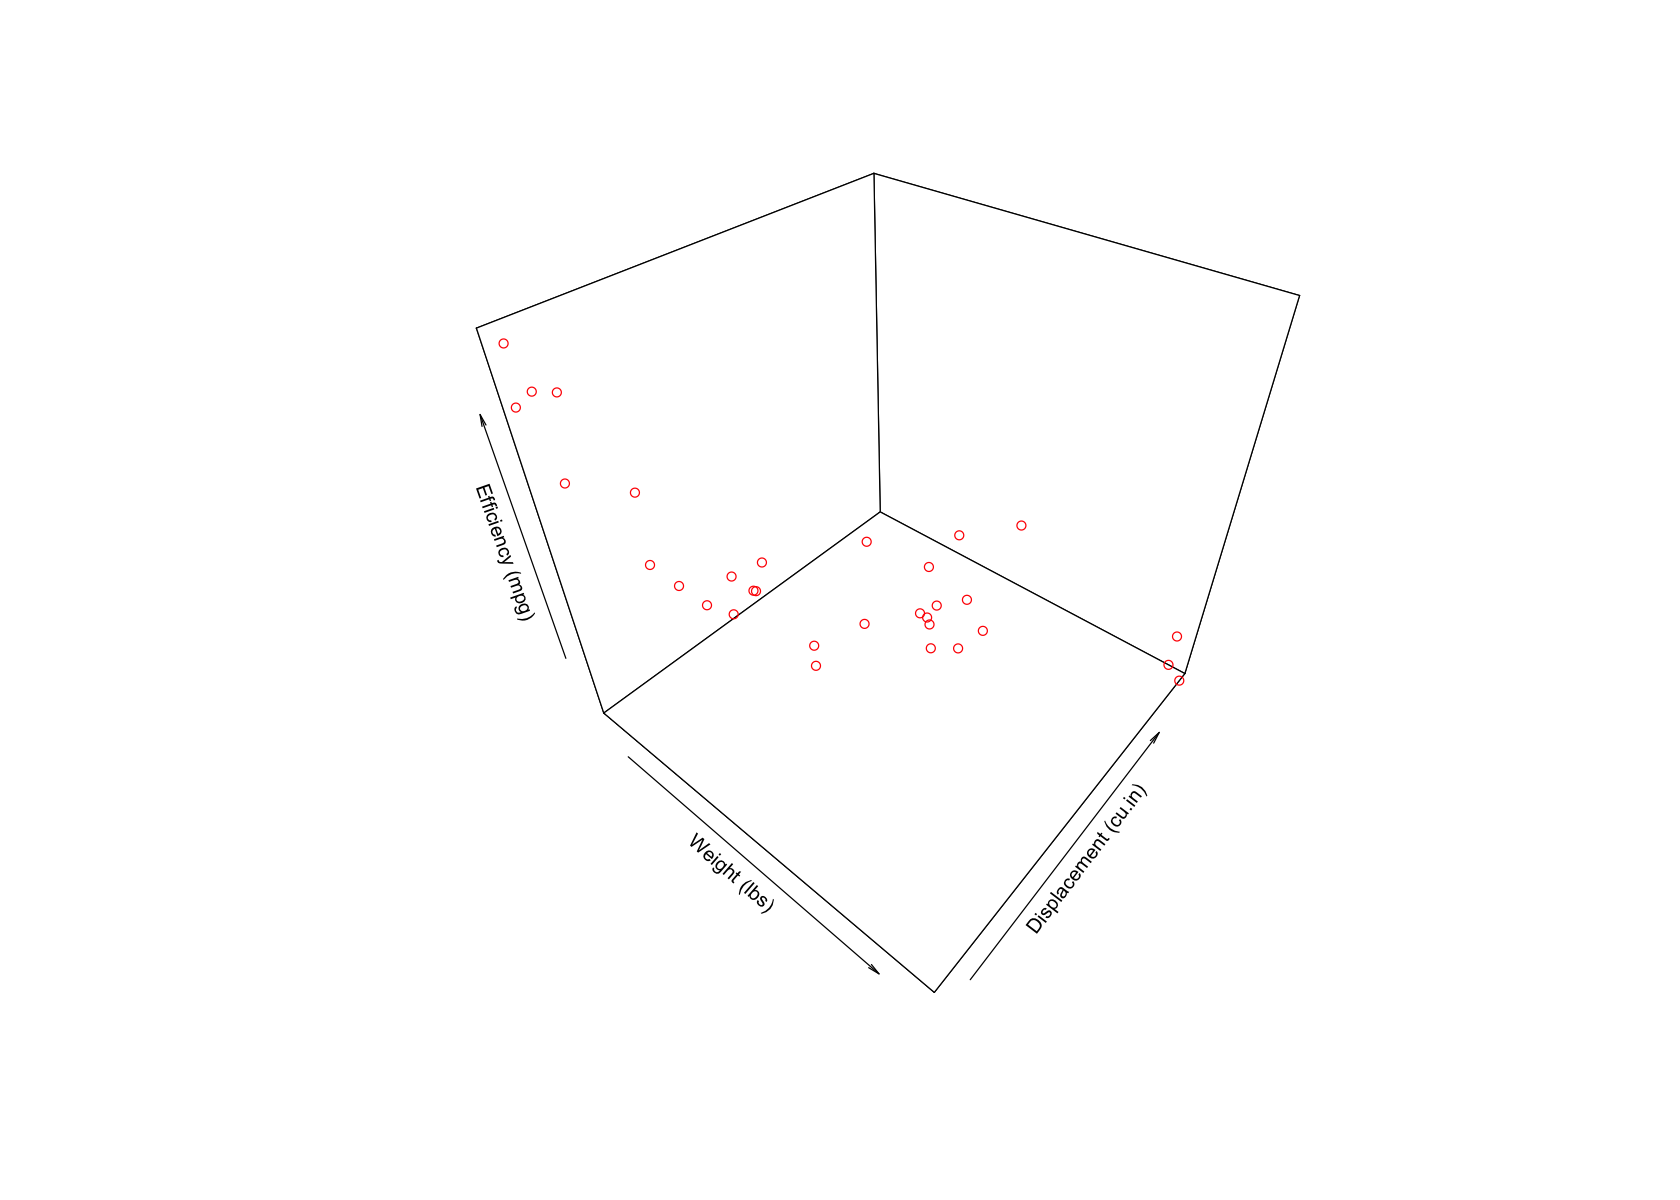

In [24]:
#visualizing data
plot(mtcars$wt,mtcars$mpg,xlab = "Weight (lbs)", ylab = "Displacement (cu.in)")
plot(mtcars$disp,mtcars$mpg,xlab = "Weight (lbs)", ylab = "Displacement (cu.in)")
X <- points3D(mtcars$wt,mtcars$disp,mtcars$mpg, col = "red",xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)")

### Question 3.1 - Quadratic Fits
Based on the regression fits, model two (w/weight) performs better than model one (w/displacement). Both all features were significant in each model, however, model two performed better than model one. The latter had an adjusted R-Squared of 0.8066 and its residual plots showed approximately linear patterns. Similarly, the QQ plot of model two showed more points closer to the line as a opposed to model one. 

#### Quadractic Fit with Displacemnt


Call:
lm(formula = mpg ~ poly(disp, 2, raw = TRUE), data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9112 -1.5269 -0.3124  1.3489  5.3946 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 3.583e+01  2.209e+00  16.221 4.39e-16 ***
poly(disp, 2, raw = TRUE)1 -1.053e-01  2.028e-02  -5.192 1.49e-05 ***
poly(disp, 2, raw = TRUE)2  1.255e-04  3.891e-05   3.226   0.0031 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.837 on 29 degrees of freedom
Multiple R-squared:  0.7927,	Adjusted R-squared:  0.7784 
F-statistic: 55.46 on 2 and 29 DF,  p-value: 1.229e-10


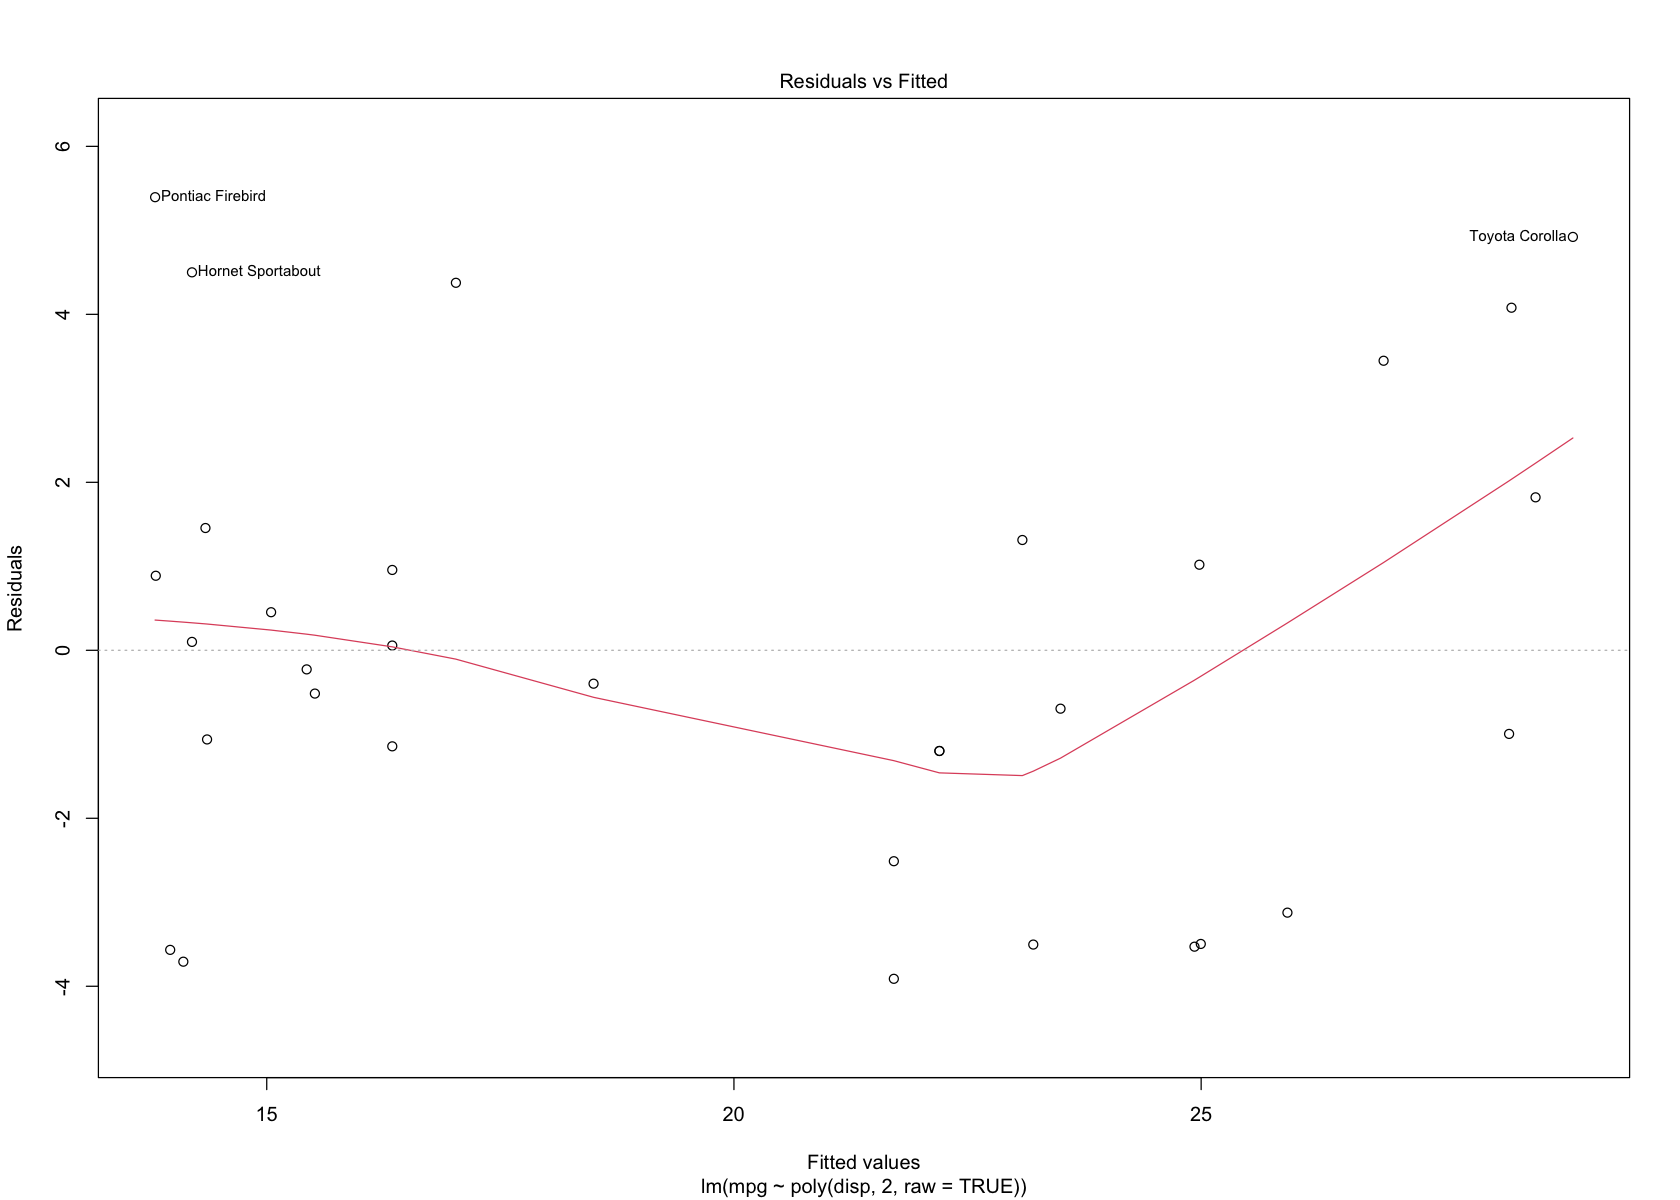

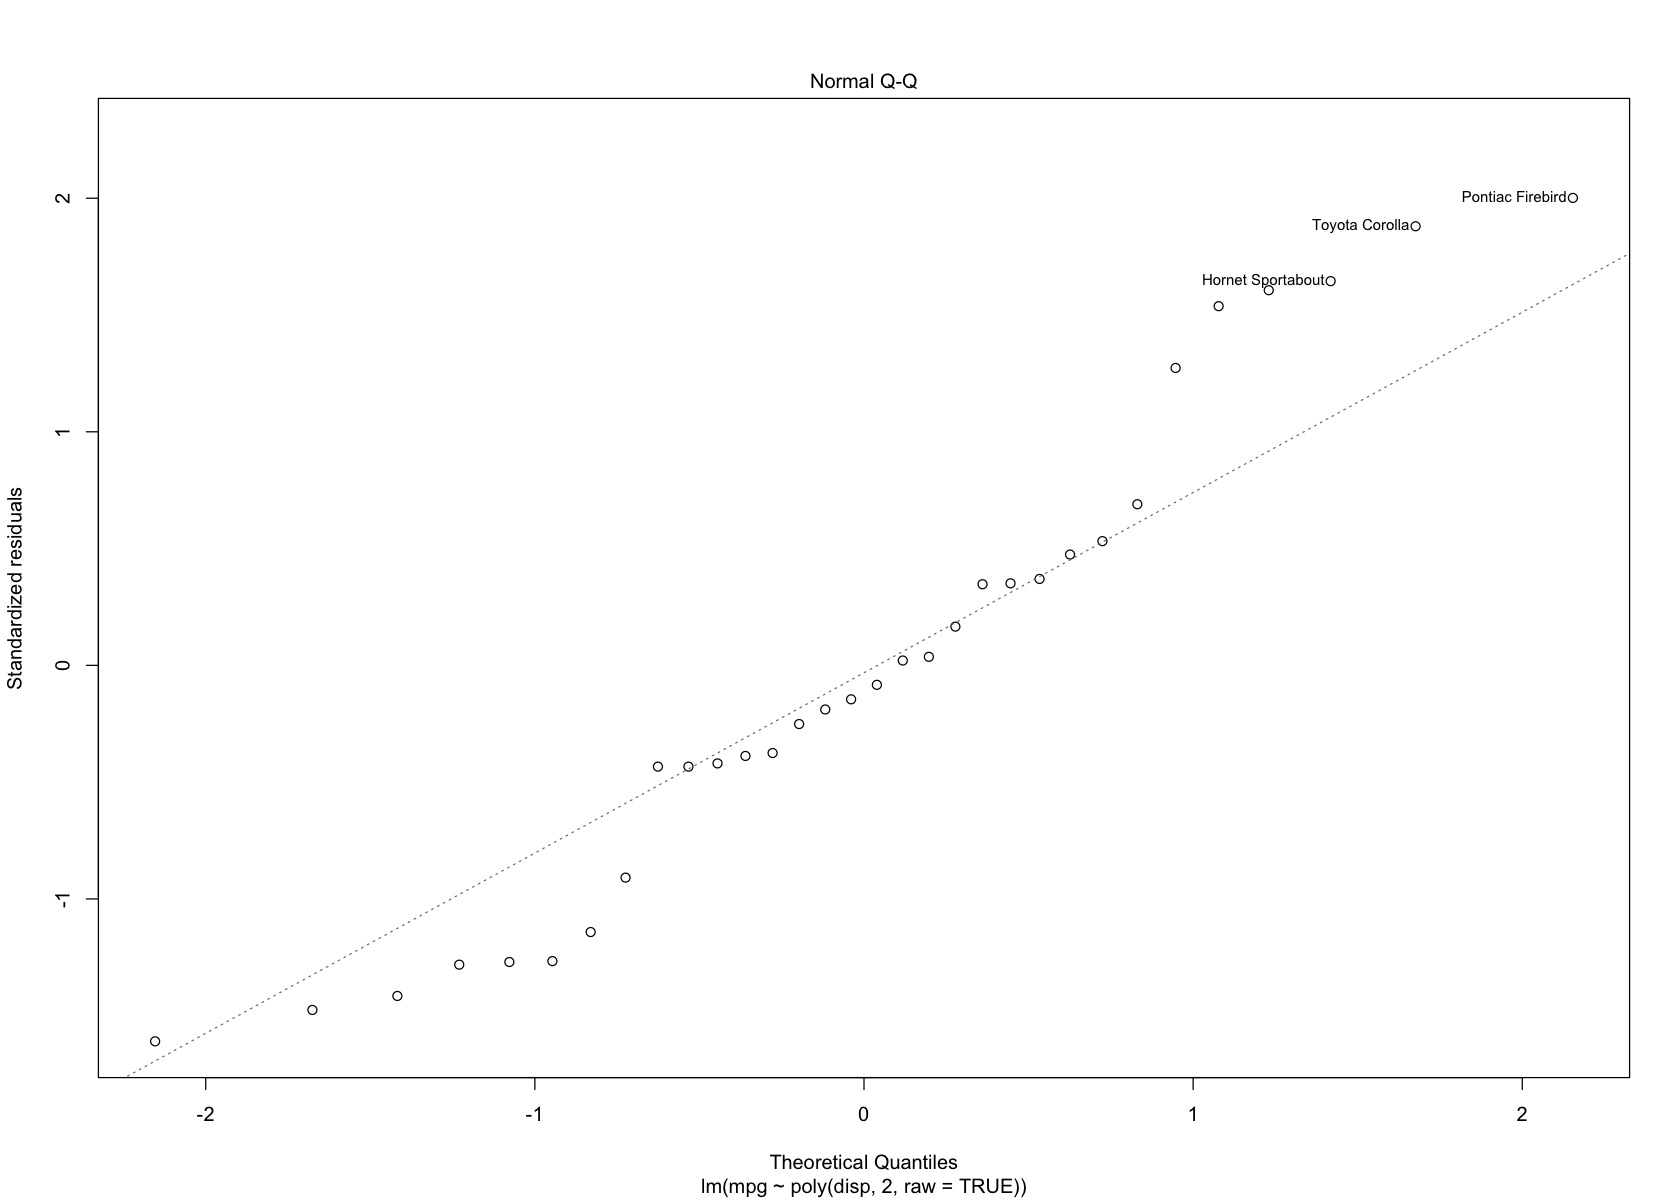

In [25]:
#first quadractic fit
quad.1 <- lm(mpg~ poly(disp,2, raw = TRUE),data=mtcars)
summary(quad.1)
plot(quad.1,1:2)

#### Quadractic Fit with Weight


Call:
lm(formula = mpg ~ poly(wt, 2, raw = TRUE), data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-3.483 -1.998 -0.773  1.462  6.238 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               49.9308     4.2113  11.856 1.21e-12 ***
poly(wt, 2, raw = TRUE)1 -13.3803     2.5140  -5.322 1.04e-05 ***
poly(wt, 2, raw = TRUE)2   1.1711     0.3594   3.258  0.00286 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.651 on 29 degrees of freedom
Multiple R-squared:  0.8191,	Adjusted R-squared:  0.8066 
F-statistic: 65.64 on 2 and 29 DF,  p-value: 1.715e-11


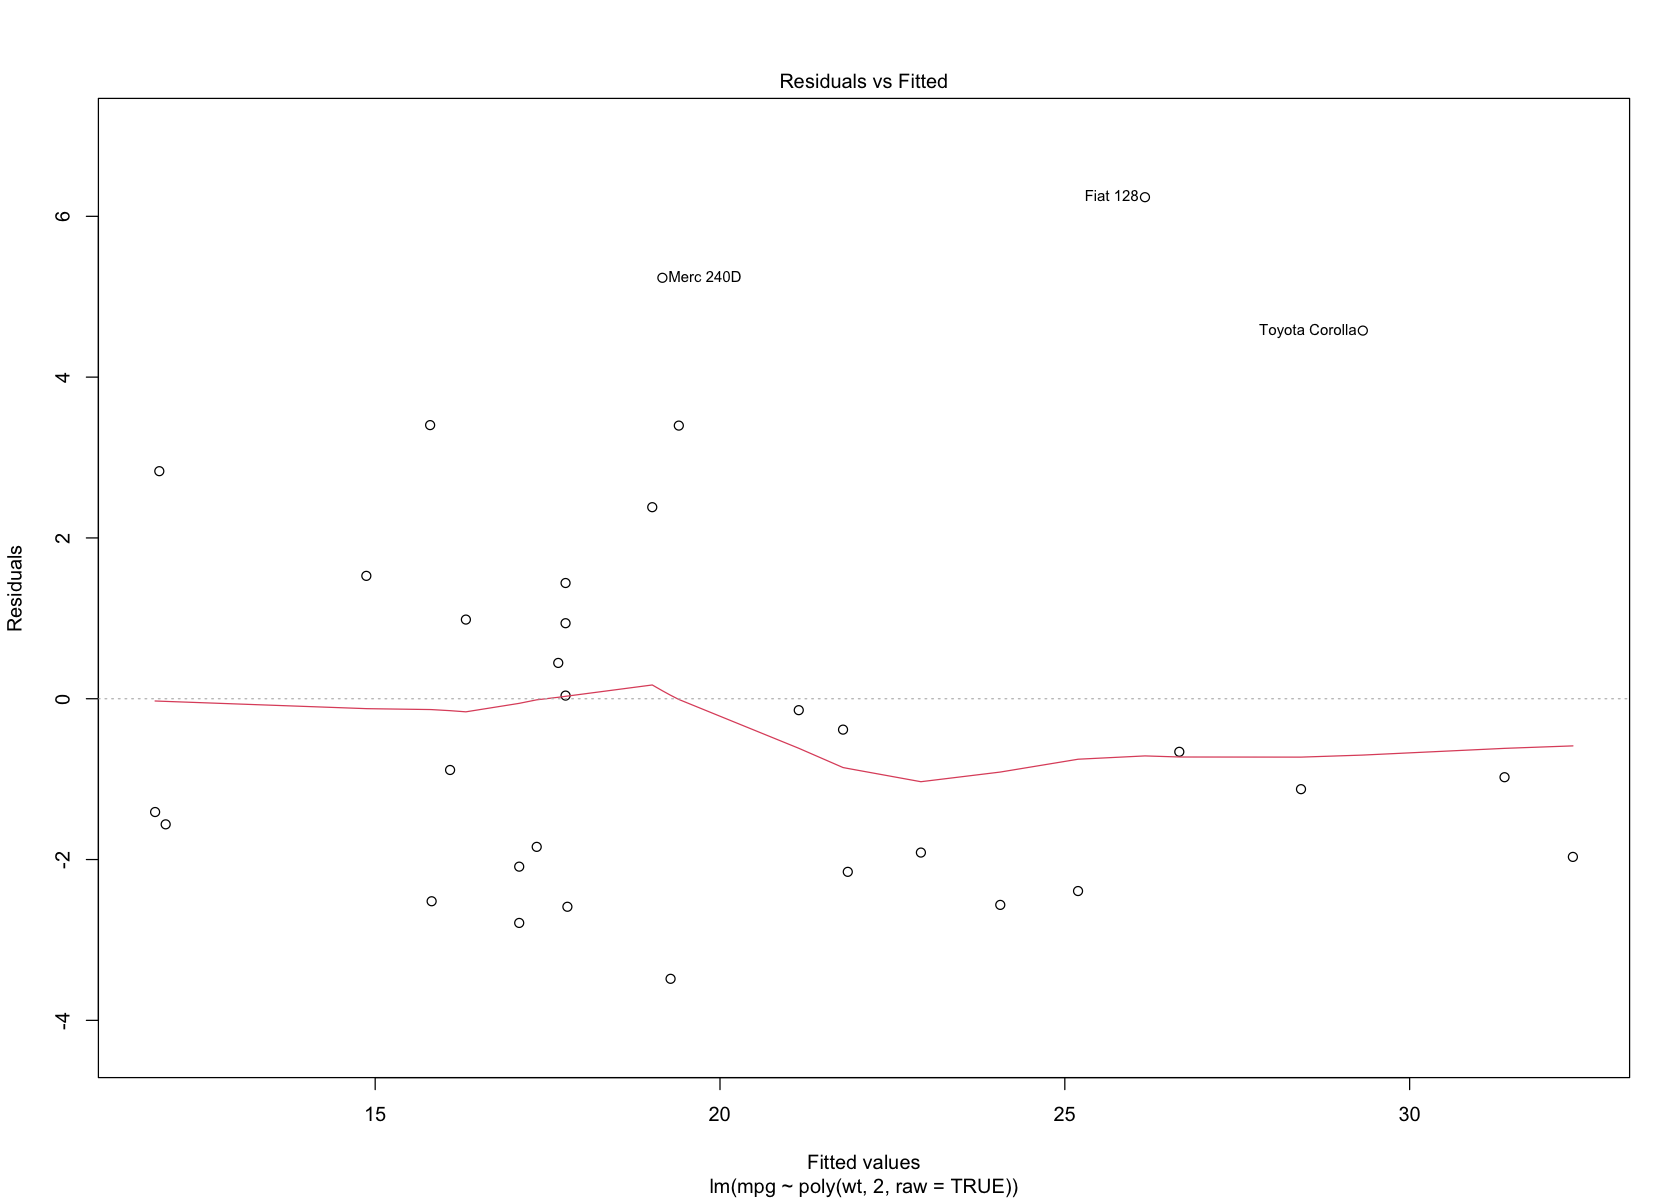

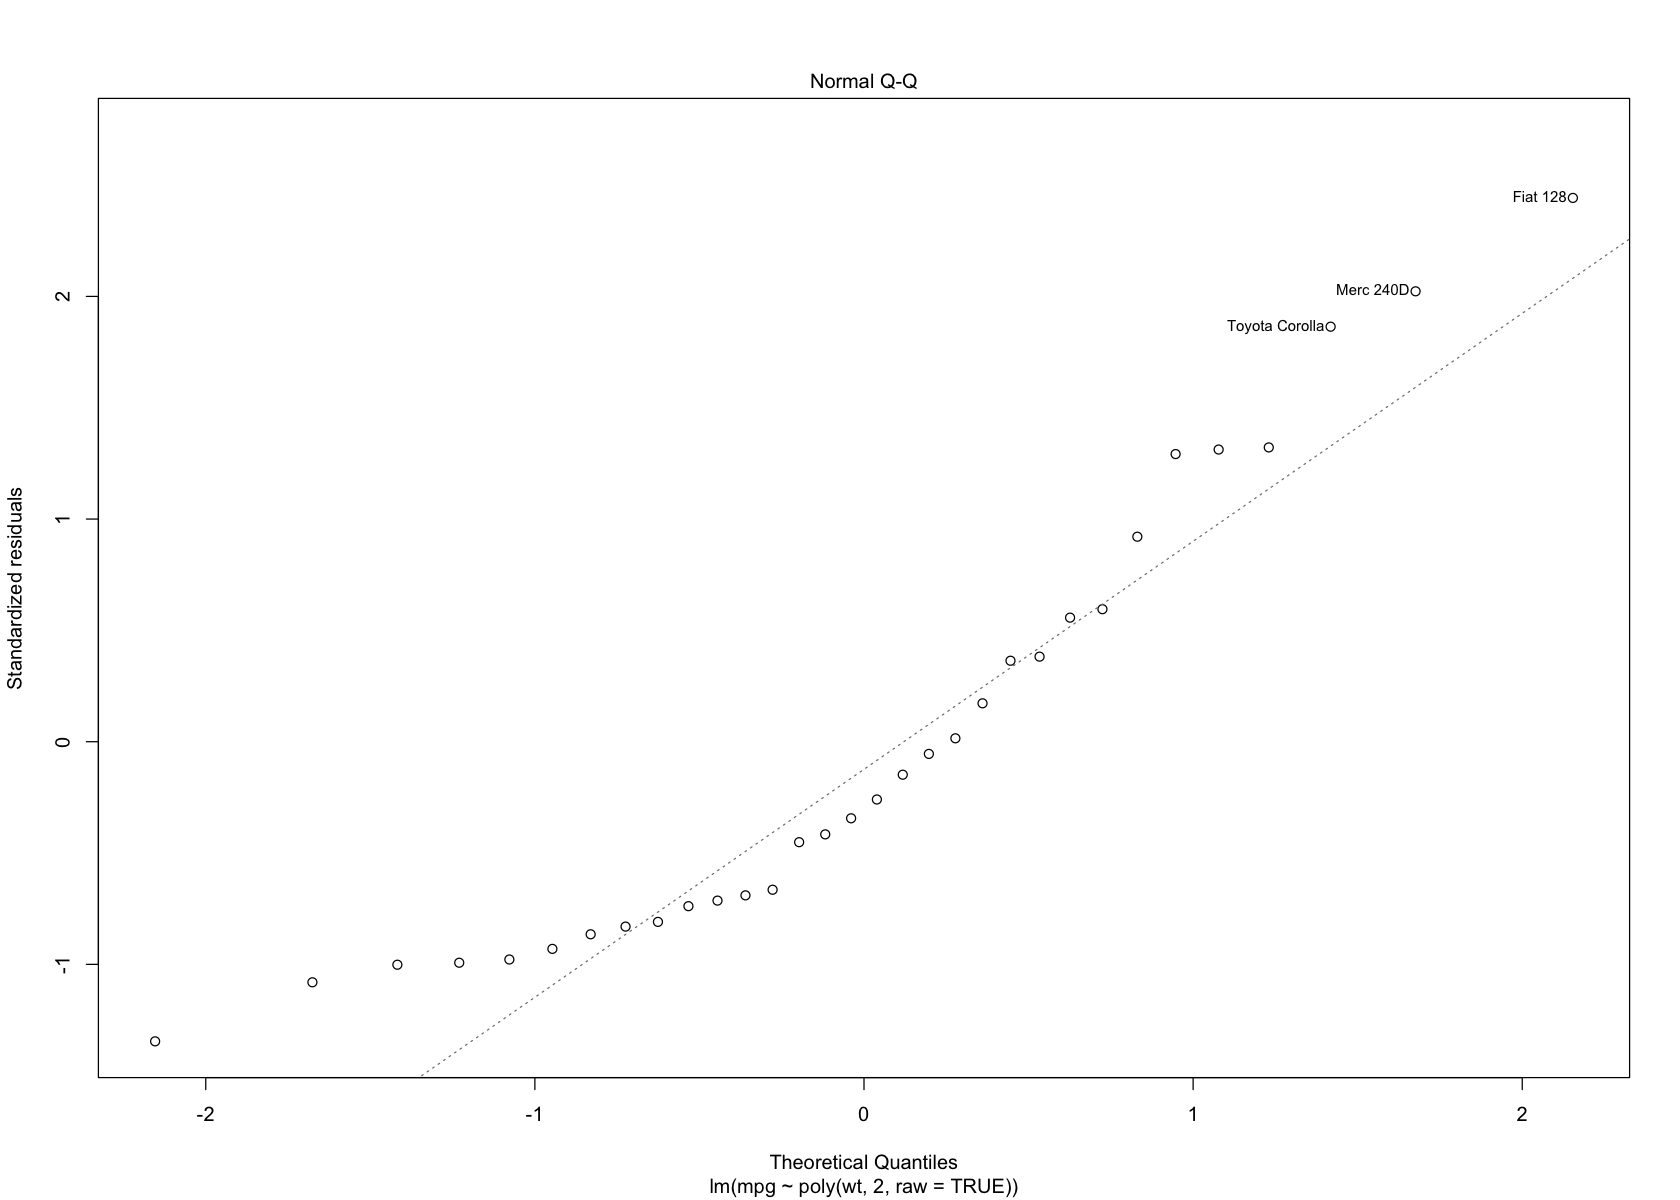

In [26]:
quad.2 <- lm(mpg~ poly(wt,2, raw = TRUE),data=mtcars)
summary(quad.2)
plot(quad.2,1:2)

#### Visualizing fitted and observed values

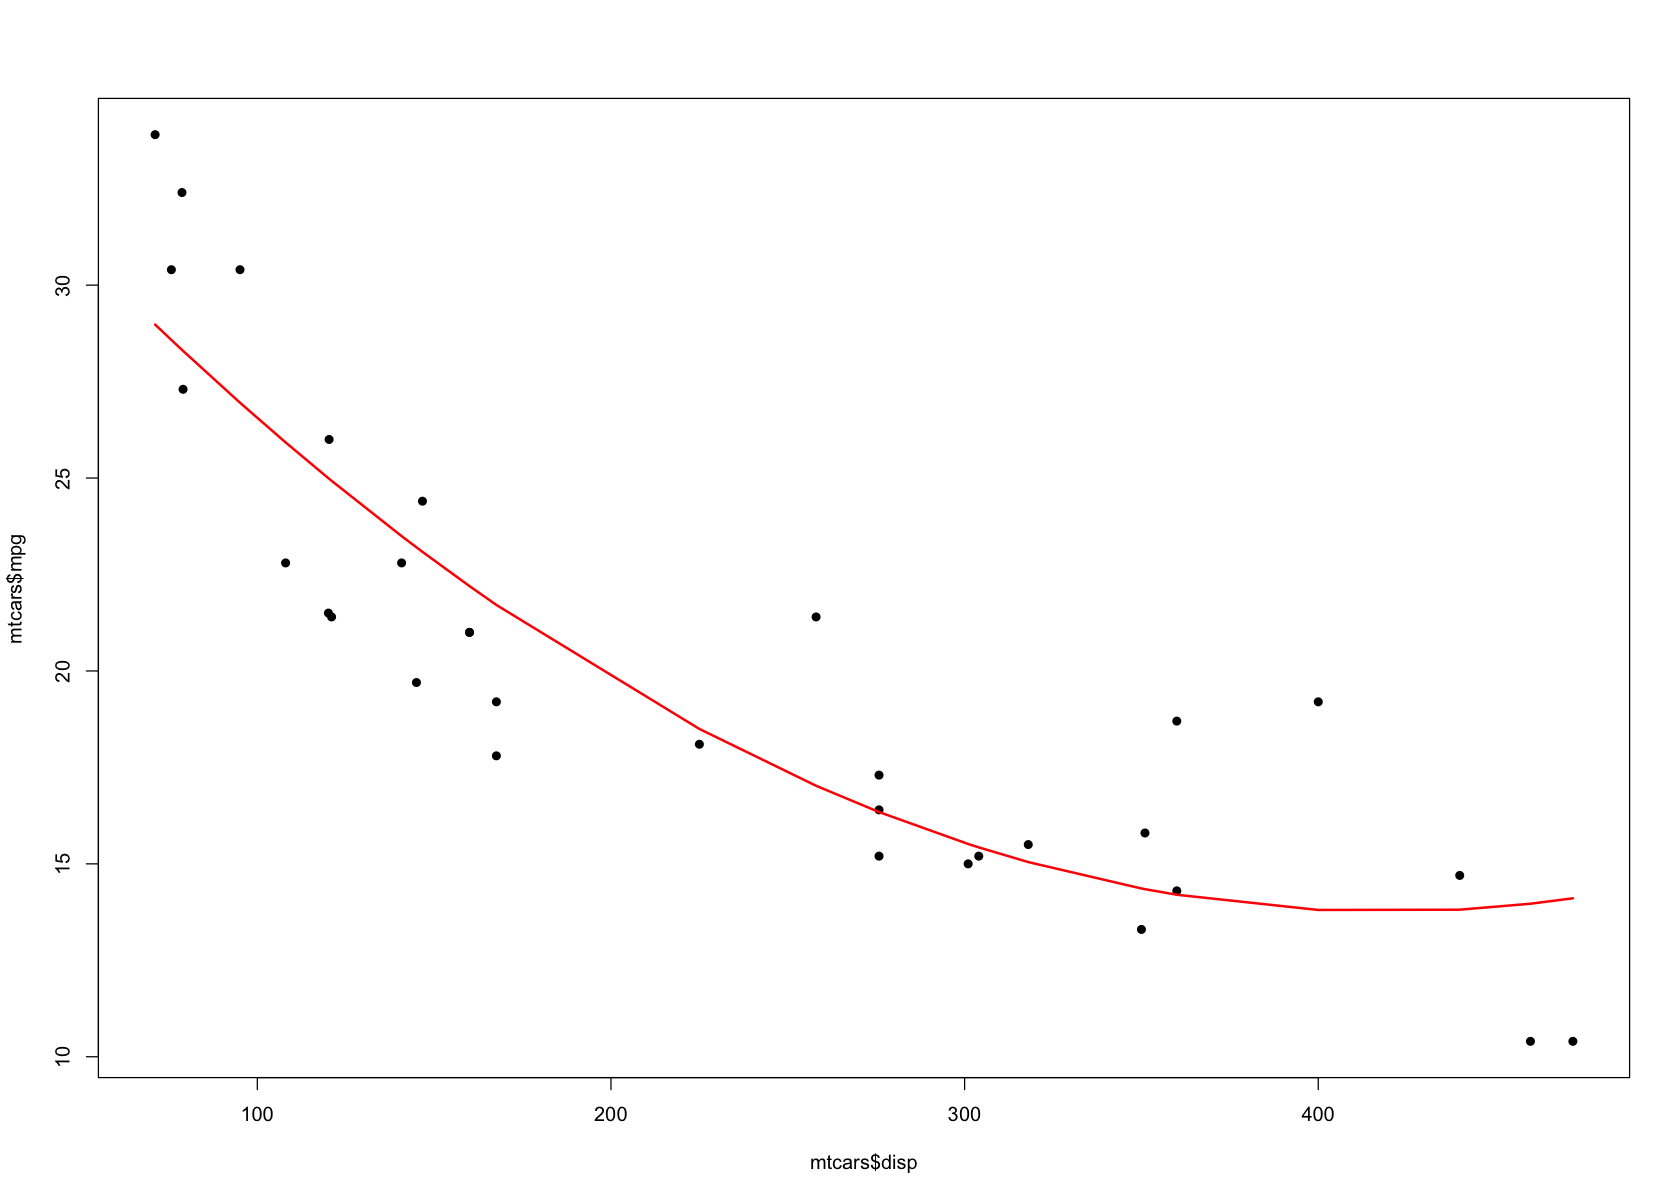

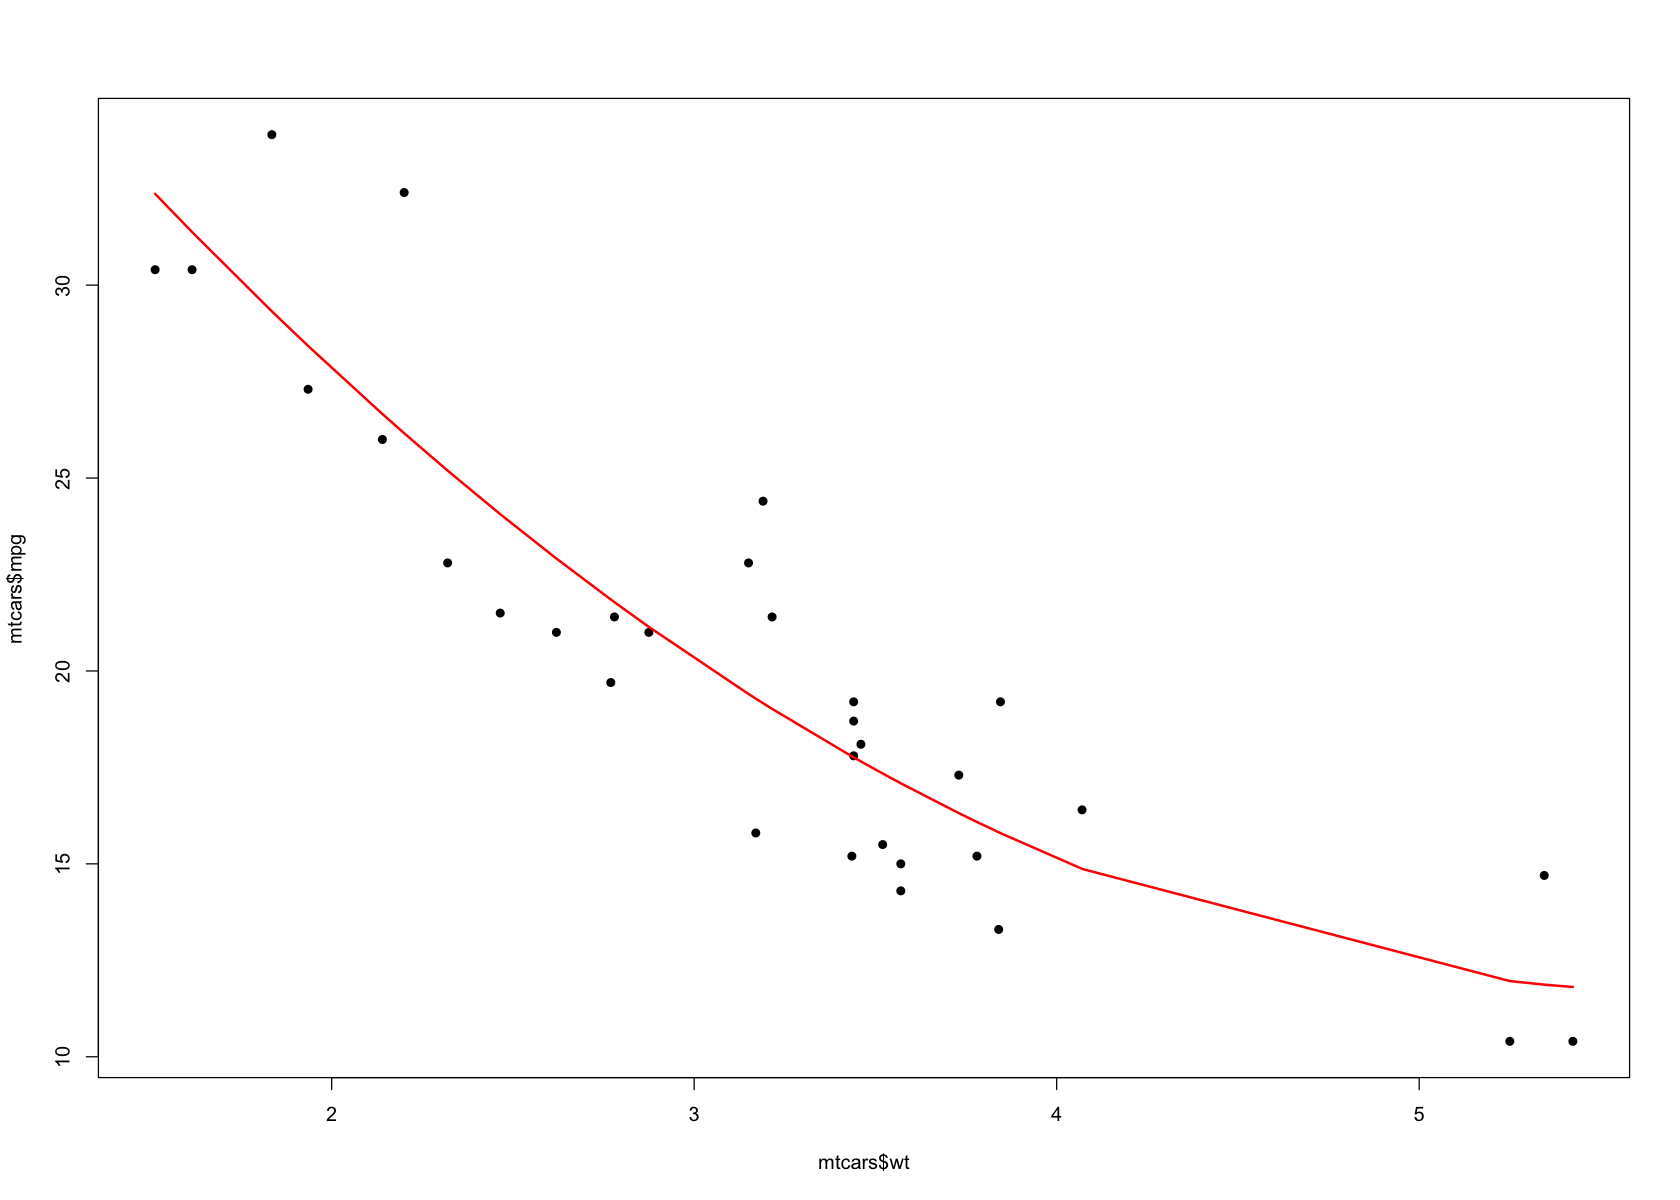

In [27]:
#index for polynomial curve with disp
ix.1 <- sort(mtcars$disp, index.return=T)$ix

plot(mtcars$disp,mtcars$mpg, pch=16)
lines(mtcars$disp[ix.1], quad.1$fitted.values[ix.1], col ='red', lwd = 2)

#index for polynomial curve with disp
ix.2 <- sort(mtcars$wt, index.return=T)$ix

plot(mtcars$wt,mtcars$mpg, pch=16)
lines(mtcars$wt[ix.2], quad.2$fitted.values[ix.2], col ='red', lwd = 2)

### Question 3.2 Interaction Terms
This model performs better than model 2 as it's adjusted R squared is 0.8373 and its residual plot was marginally better. However, it's QQ plot shows more of the points closer to the lines indicating a better fit of the data. Similarly, looking at the 3D plots of the regression planes with observed data, we see that the estimated planes fit their respective cylinder groups relatively well. These visuals lend some support to the robustness of this model. 

#### Interaction terms Fit

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),41.1350198,3.10231810,13.2594462,2.941475e-12
wt,-0.6978035,2.49720006,-0.2794344,7.824090e-01
as.factor(cyl)6,-12.9466721,8.89942792,-1.4547758,1.592441e-01
as.factor(cyl)8,-17.0571646,4.79272664,-3.5589688,1.669560e-03
disp,-0.1224733,0.05293004,-2.3138709,2.995898e-02
wt:as.factor(cyl)6,-3.1372923,3.91677516,-0.8009886,4.313354e-01
wt:as.factor(cyl)8,-1.3253343,2.81232996,-0.4712585,6.418956e-01
as.factor(cyl)6:disp,0.1416155,0.05891432,2.4037543,2.468297e-02
as.factor(cyl)8:disp,0.1199615,0.05487875,2.1859381,3.925793e-02


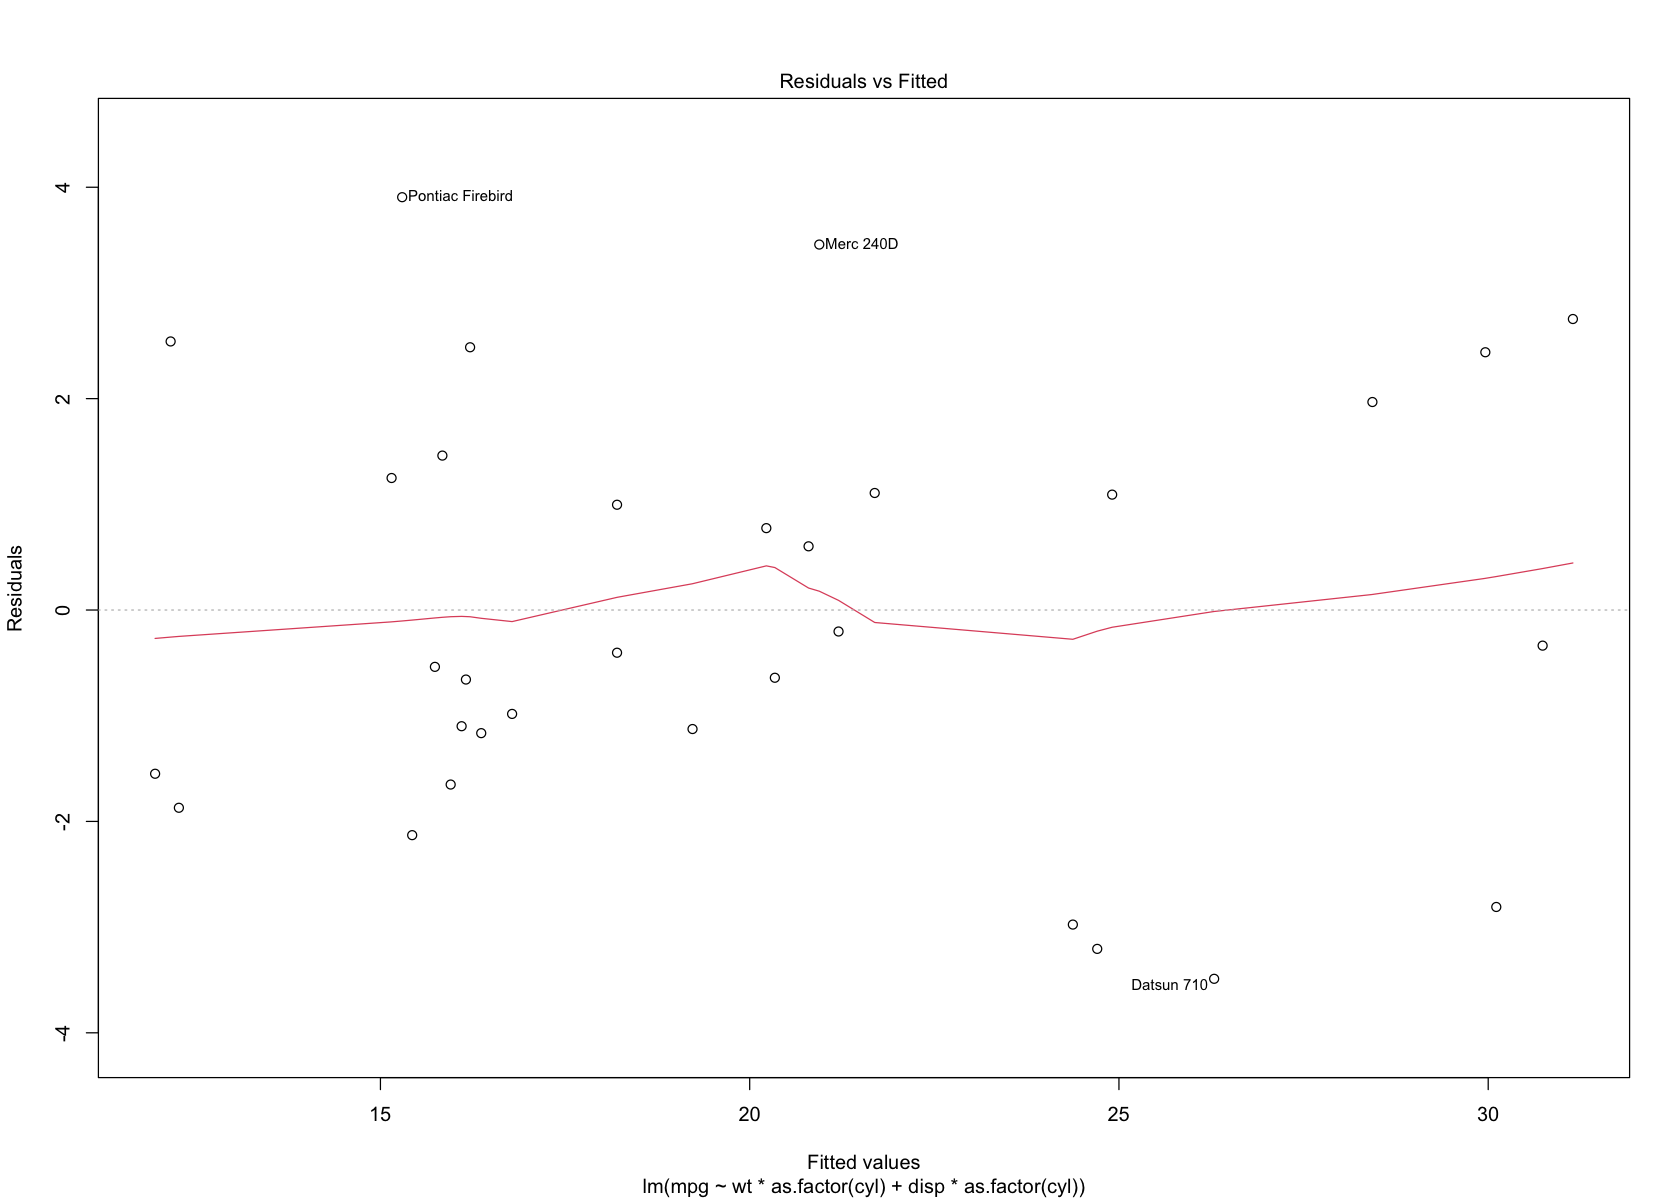

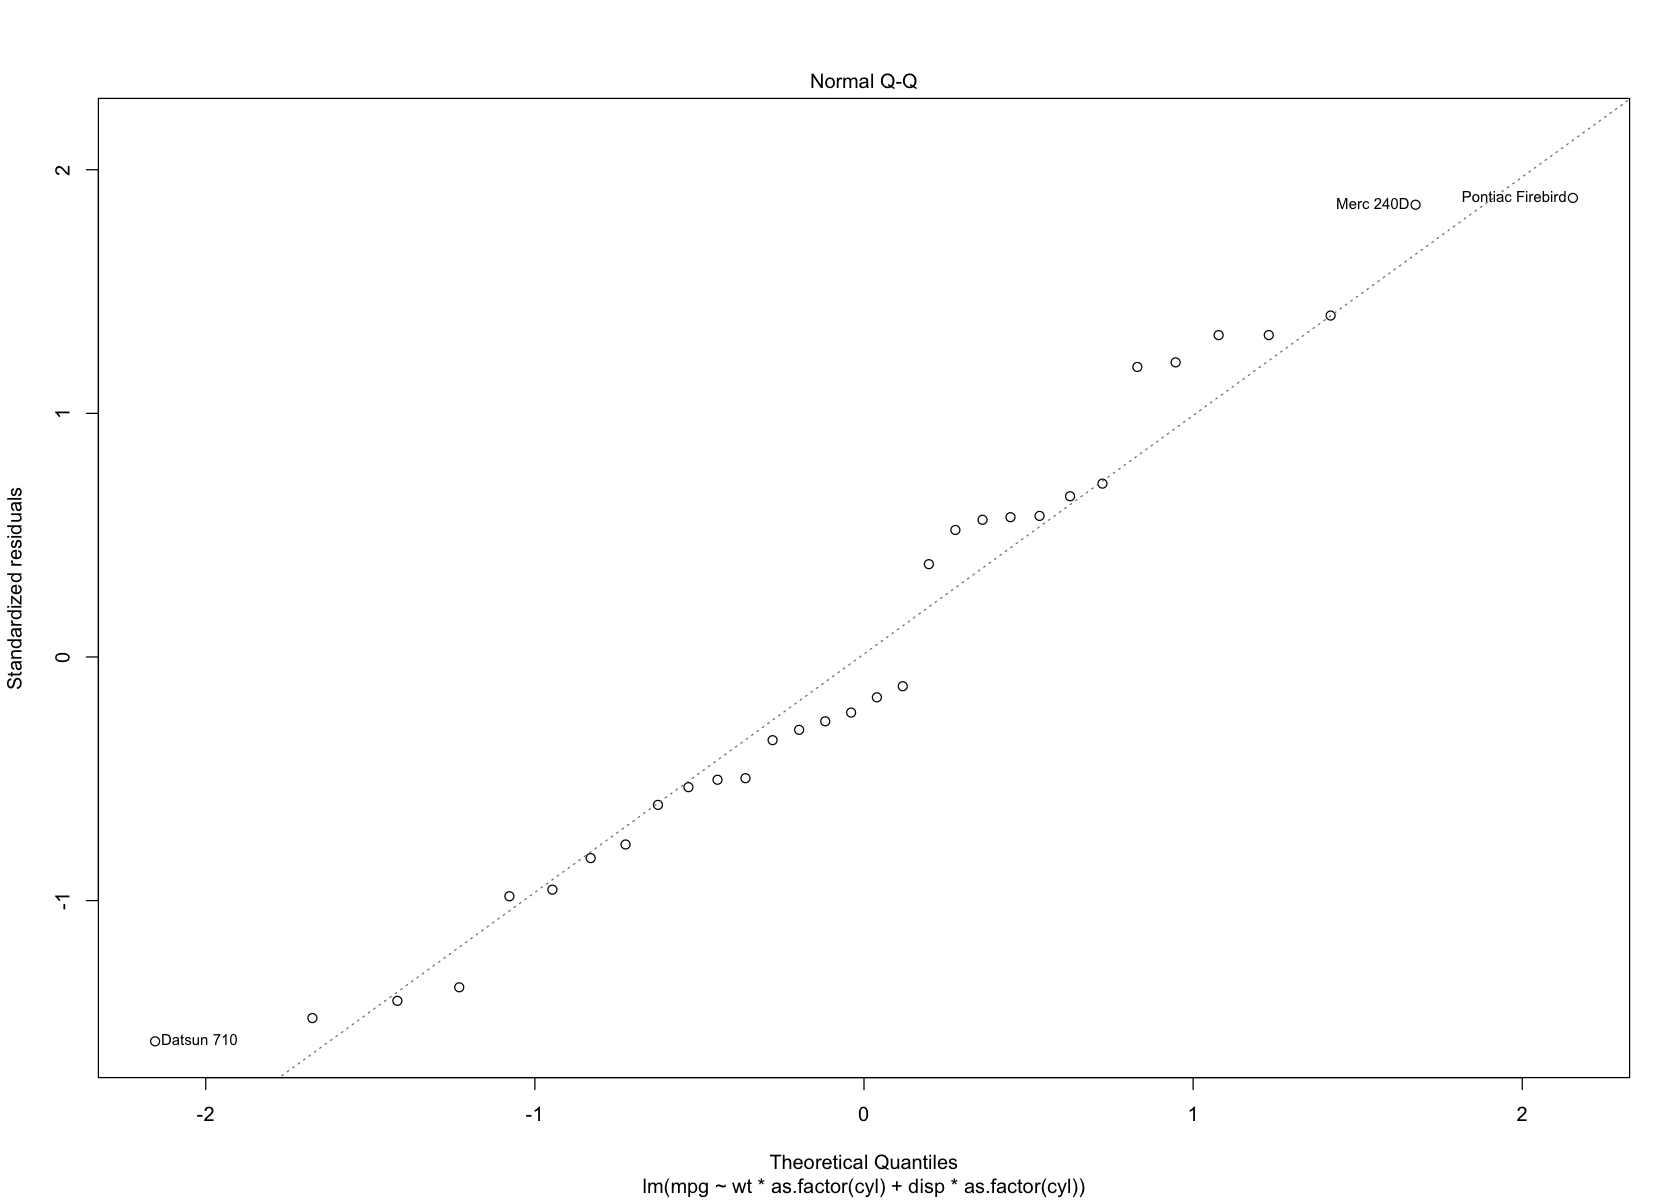

In [28]:
int.fit <- lm(mpg~ wt*as.factor(cyl) + disp*as.factor(cyl),data=mtcars)
ix.3 <- rev(sort(int.fit$fitted.values, index.return=T)$ix)

summary(int.fit)$coefficients
plot(int.fit,1:2)

#### Visualizing Results

In [33]:
#setting up 3D plots for results
wt = seq(min(mtcars$wt), max(mtcars$wt), length.out = 100)
disp = seq(min(mtcars$disp), max(mtcars$disp), length.out = 100)

Z.4 <- outer(wt,disp, function(x,y){
    predict(int.fit, newdata = data.frame(wt=x, disp=y, cyl = 4) ) 
}
             )

Z.6 <- outer(wt,disp, function(x,y){
    predict(int.fit, newdata = data.frame(wt=x, disp=y, cyl = 6) ) 
}
             )

Z.8 <- outer(wt,disp, function(x,y){
    predict(int.fit, newdata = data.frame(wt=x, disp=y, cyl = 8) ) 
}
             )

Z.4

31.37139,30.87544,30.37948,29.88353,29.38757,28.89162,28.39566,27.89971,27.40375,26.90780,⋯,-13.26455,-13.76050,-14.25646,-14.75241,-15.24837,-15.74432,-16.24028,-16.73623,-17.23219,-17.72814
31.34383,30.84787,30.35192,29.85596,29.36001,28.86405,28.36810,27.87214,27.37619,26.88023,⋯,-13.29212,-13.78807,-14.28403,-14.77998,-15.27594,-15.77189,-16.26785,-16.76380,-17.25976,-17.75571
31.31626,30.82030,30.32435,29.82839,29.33244,28.83649,28.34053,27.84458,27.34862,26.85267,⋯,-13.31968,-13.81564,-14.31159,-14.80755,-15.30350,-15.79946,-16.29541,-16.79137,-17.28732,-17.78328
31.28869,30.79274,30.29678,29.80083,29.30487,28.80892,28.31296,27.81701,27.32105,26.82510,⋯,-13.34725,-13.84320,-14.33916,-14.83511,-15.33107,-15.82702,-16.32298,-16.81893,-17.31489,-17.81084
31.26113,30.76517,30.26922,29.77326,29.27731,28.78135,28.28540,27.78944,27.29349,26.79753,⋯,-13.37482,-13.87077,-14.36673,-14.86268,-15.35864,-15.85459,-16.35055,-16.84650,-17.34246,-17.83841
31.23356,30.73760,30.24165,29.74569,29.24974,28.75378,28.25783,27.76187,27.26592,26.76997,⋯,-13.40238,-13.89834,-14.39429,-14.89025,-15.38620,-15.88216,-16.37811,-16.87407,-17.37002,-17.86598
31.20599,30.71004,30.21408,29.71813,29.22217,28.72622,28.23026,27.73431,27.23835,26.74240,⋯,-13.42995,-13.92590,-14.42186,-14.91781,-15.41377,-15.90972,-16.40568,-16.90163,-17.39759,-17.89354
31.17843,30.68247,30.18652,29.69056,29.19461,28.69865,28.20270,27.70674,27.21079,26.71483,⋯,-13.45752,-13.95347,-14.44943,-14.94538,-15.44134,-15.93729,-16.43325,-16.92920,-17.42516,-17.92111
31.15086,30.65490,30.15895,29.66299,29.16704,28.67108,28.17513,27.67917,27.18322,26.68726,⋯,-13.48508,-13.98104,-14.47699,-14.97295,-15.46890,-15.96486,-16.46081,-16.95677,-17.45272,-17.94868
31.12329,30.62734,30.13138,29.63543,29.13947,28.64352,28.14756,27.65161,27.15565,26.65970,⋯,-13.51265,-14.00861,-14.50456,-15.00051,-15.49647,-15.99242,-16.48838,-16.98433,-17.48029,-17.97624
31.09573,30.59977,30.10382,29.60786,29.11191,28.61595,28.12000,27.62404,27.12809,26.63213,⋯,-13.54022,-14.03617,-14.53213,-15.02808,-15.52404,-16.01999,-16.51595,-17.01190,-17.50786,-18.00381


##### Interaction with 4 cylinders

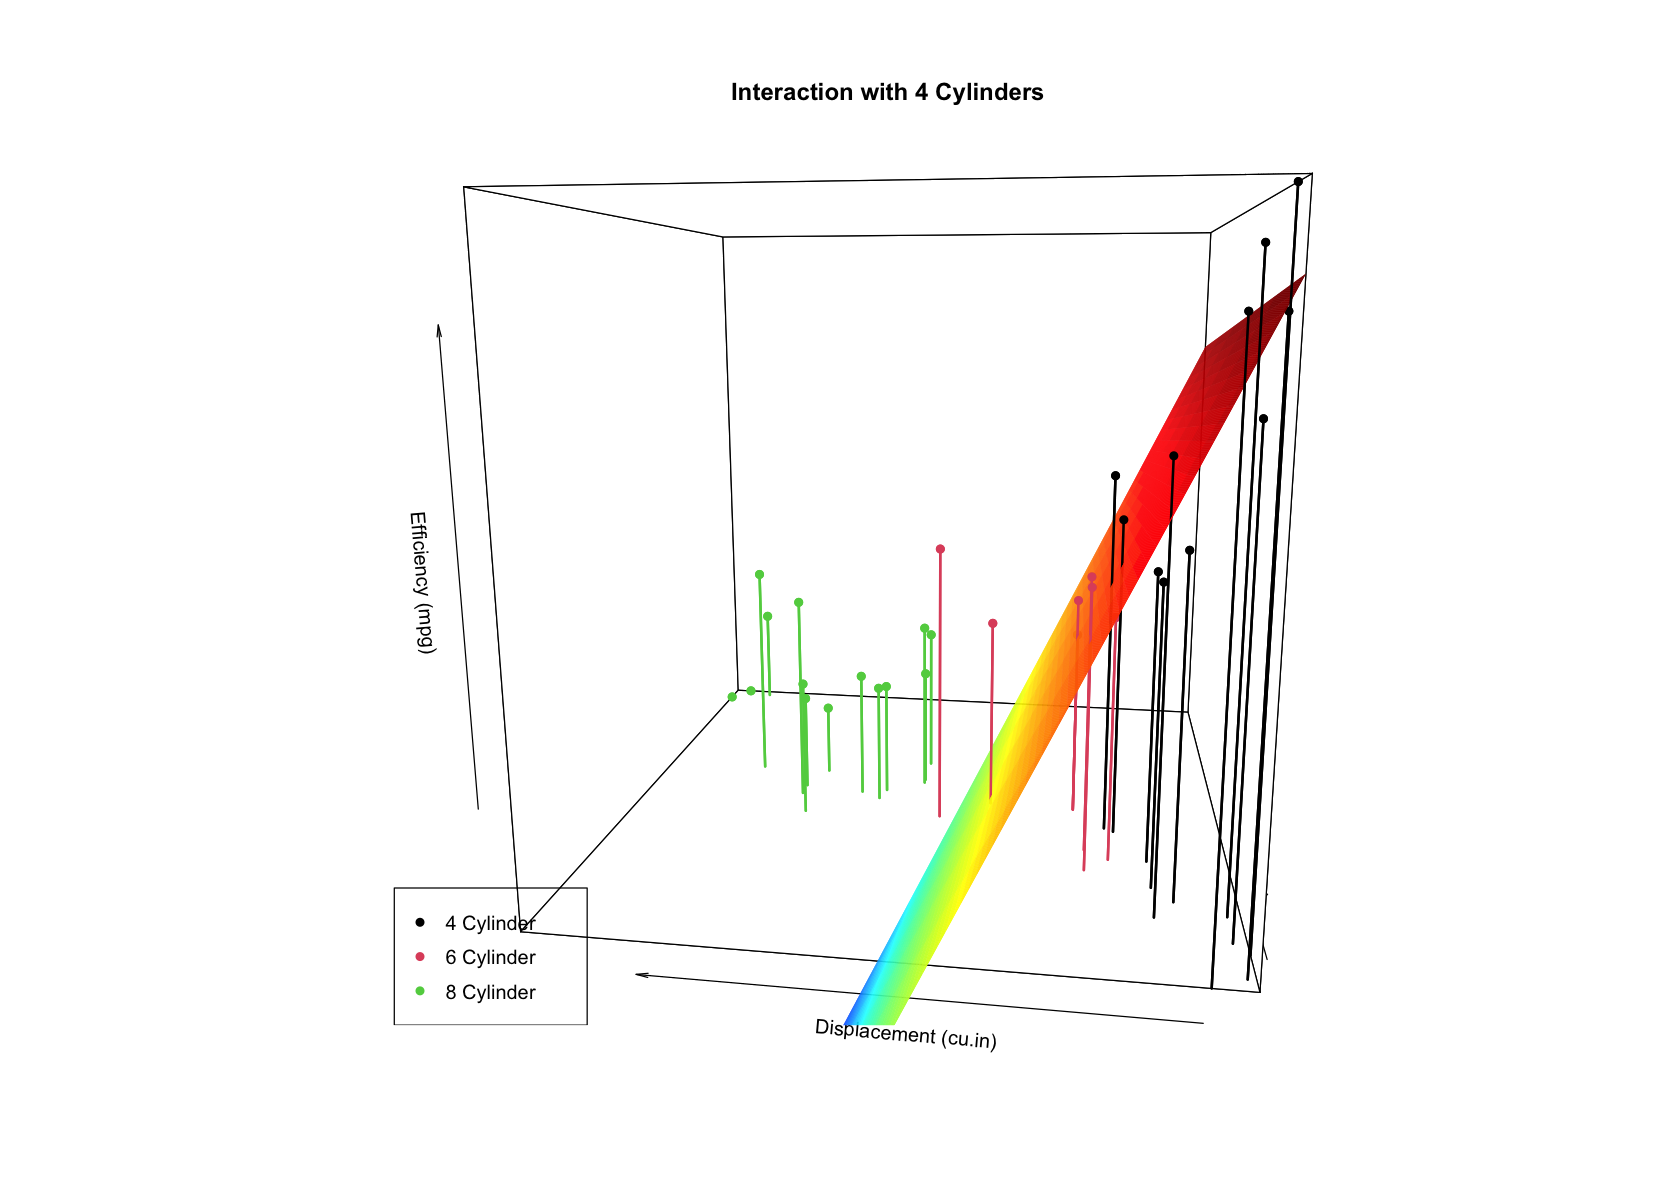

In [511]:
scatter3D(mtcars$wt,mtcars$disp,mtcars$mpg, xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)",
          type = "h", lwd = 2, col = as.factor(mtcars$cyl), theta = -82, phi = 11, colkey = F, colvar = NA, pch=16, lwd=2,
         main="Interaction with 4 Cylinders")  #colvar = NA turns off warning message
persp3D(wt, disp, Z.4, add=TRUE, colkey = F) 
legend("bottomleft", legend = c("4 Cylinder", "6 Cylinder", "8 Cylinder"), col= 1:3, , cex=1, pch=16)

##### Interaction with 6 cylinders

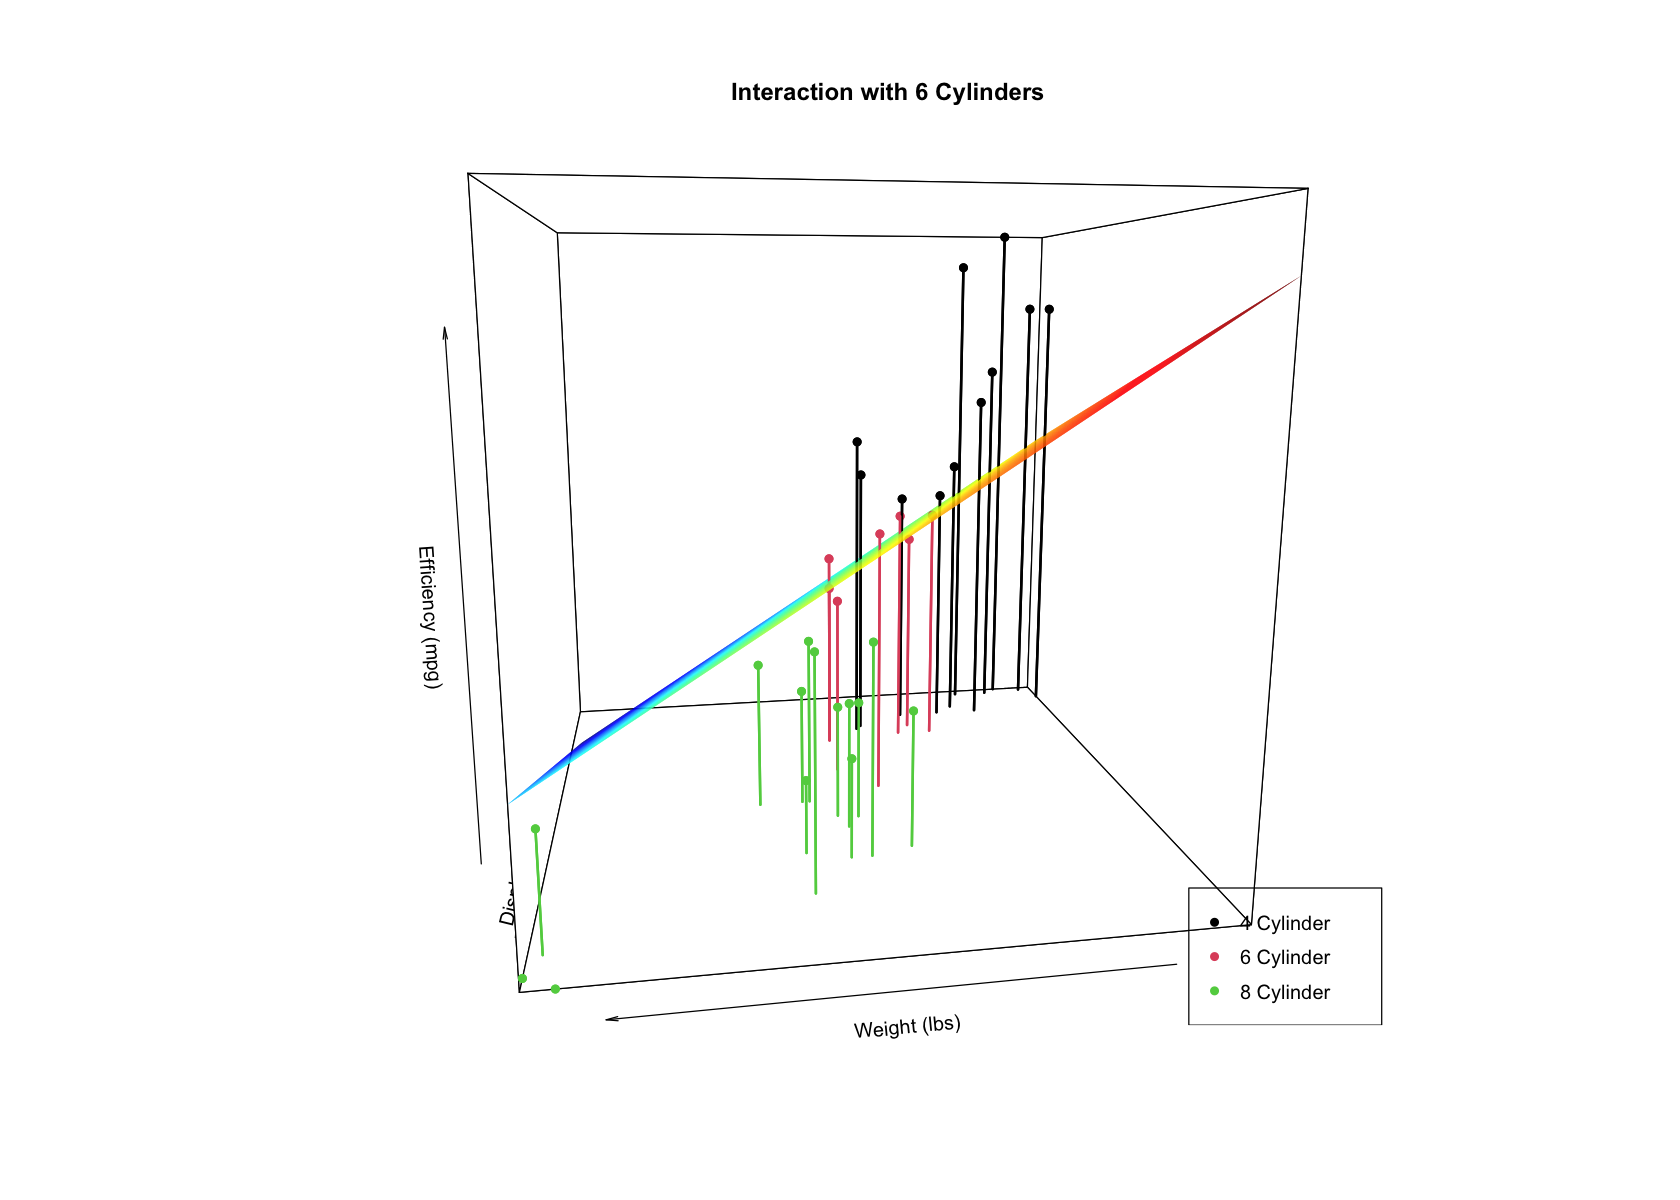

In [512]:
scatter3D(mtcars$wt,mtcars$disp,mtcars$mpg, type = "h", col = as.factor(mtcars$cyl), theta=171,phi=11,
         xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)", colkey = F, lwd = 2, colvar = NA, pch=16,
         main="Interaction with 6 Cylinders")
persp3D(wt, disp, Z.6, xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)", add = TRUE, colkey = F)
legend("bottomright", legend = c("4 Cylinder", "6 Cylinder", "8 Cylinder"), col= 1:3, , cex=1, pch=16)

##### Interaction with 8 cylinders

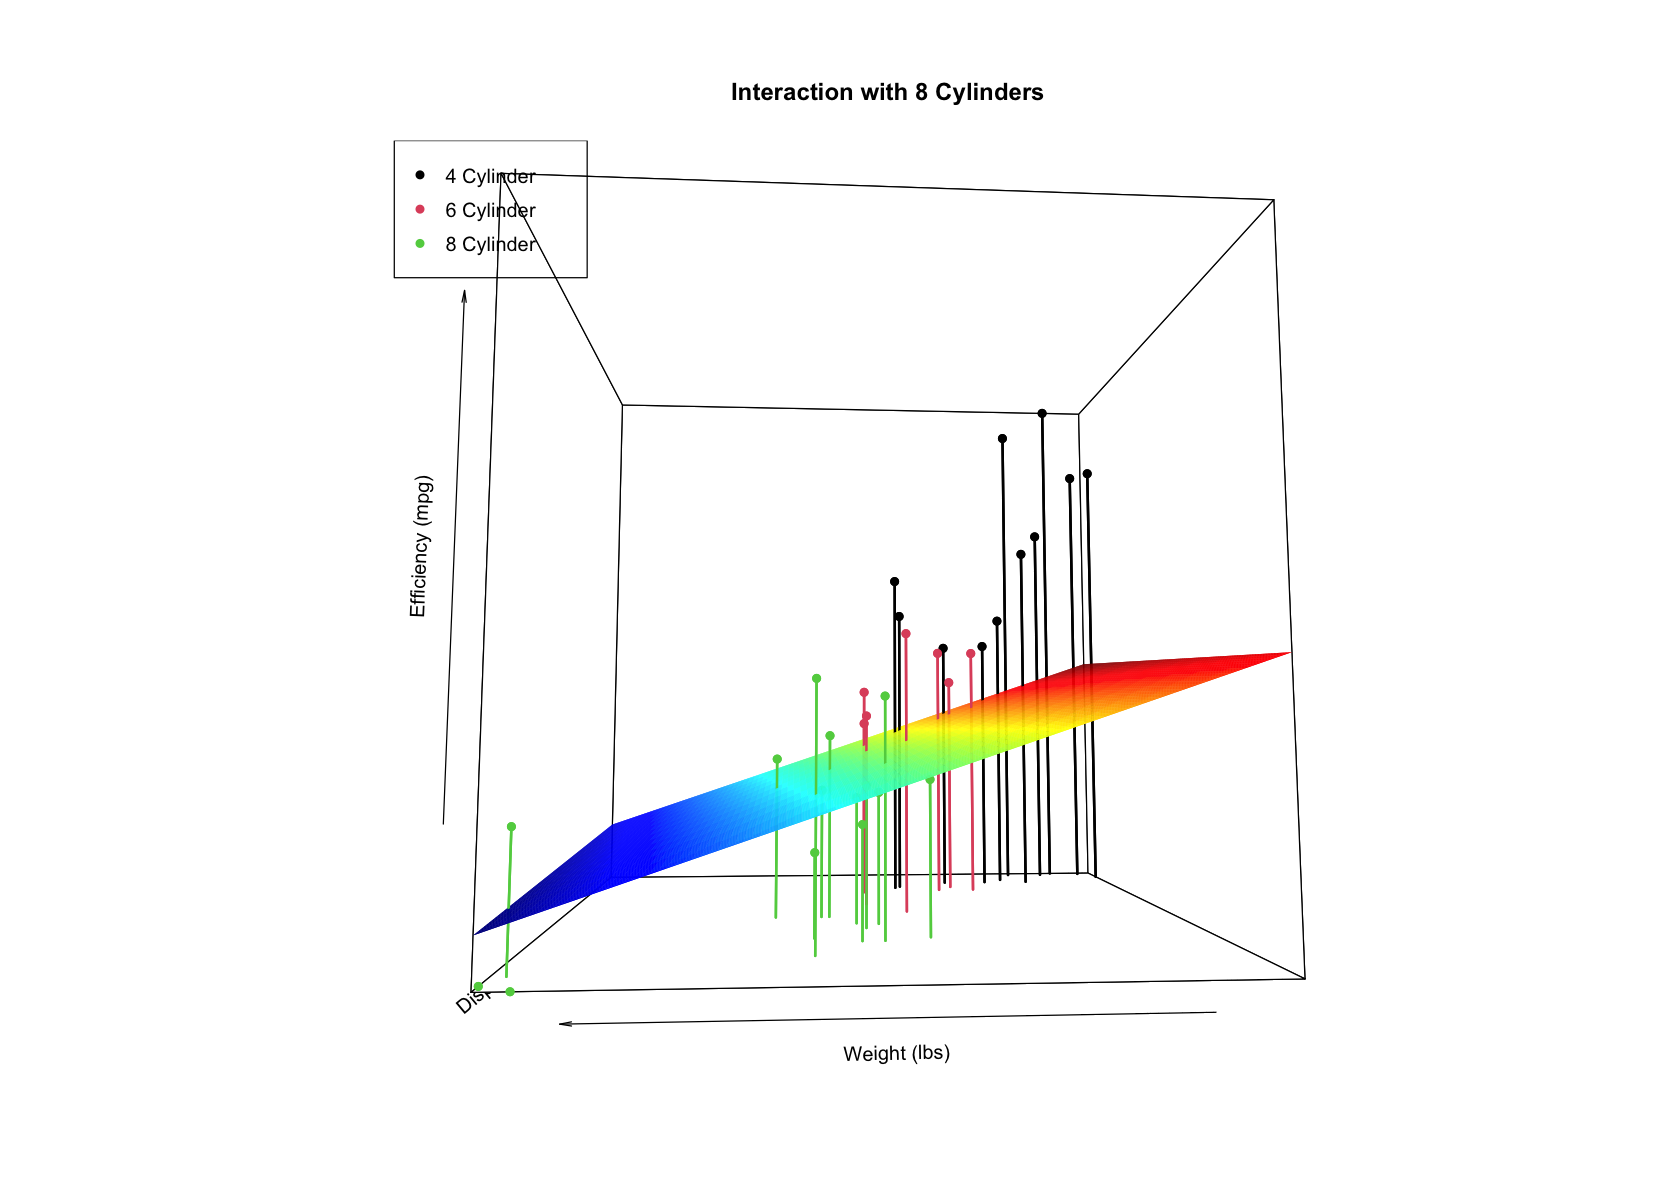

In [516]:
scatter3D(mtcars$wt,mtcars$disp,mtcars$mpg, type = "h", col = as.factor(mtcars$cyl), theta=176,phi=-6,
         xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)", colkey = F, colvar = NA, pch=16, lwd=2,
         main="Interaction with 8 Cylinders")
persp3D(wt, disp, Z.8, xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)", add = TRUE, colkey = F)
legend("topleft", legend = c("4 Cylinder", "6 Cylinder", "8 Cylinder"), col= 1:3, pch=16)

In [61]:
grid.lines = 40

x <- mtcars$disp
y <- mtcars$wt
z <- mtcars$mpg
# w <- mtcars$cyl

fit <- lm(z ~ x + y)


x.pred <- seq(min(x), max(x), length.out = grid.lines)
y.pred <- seq(min(y), max(y), length.out = grid.lines)

xy <- expand.grid( x = x.pred, y = y.pred)


z.pred <- matrix(predict(fit, newdata = xy), 
                 nrow = grid.lines, ncol = grid)

# create the fitted points for droplines to the surface
# fitpoints <- fit$fitted.values

# scatter plot with regression plane
# scatter3D(x, y, z, pch = 19, cex = 1,colvar = NULL, col="red", 
#           theta = 50, phi = 10, bty="b",
#           xlab = "Weight (lbs)", ylab = "Displacement (cu.in)", zlab = "Efficiency (mpg)",  
#           surf = list(x = x.pred, y = y.pred, z = z.pred,  
#                       facets = TRUE, fit = fitpoints, col=ramp.col (col = c("dodgerblue3","seagreen2"), n = 300, alpha=0.9), border="black"), main = "Cars")

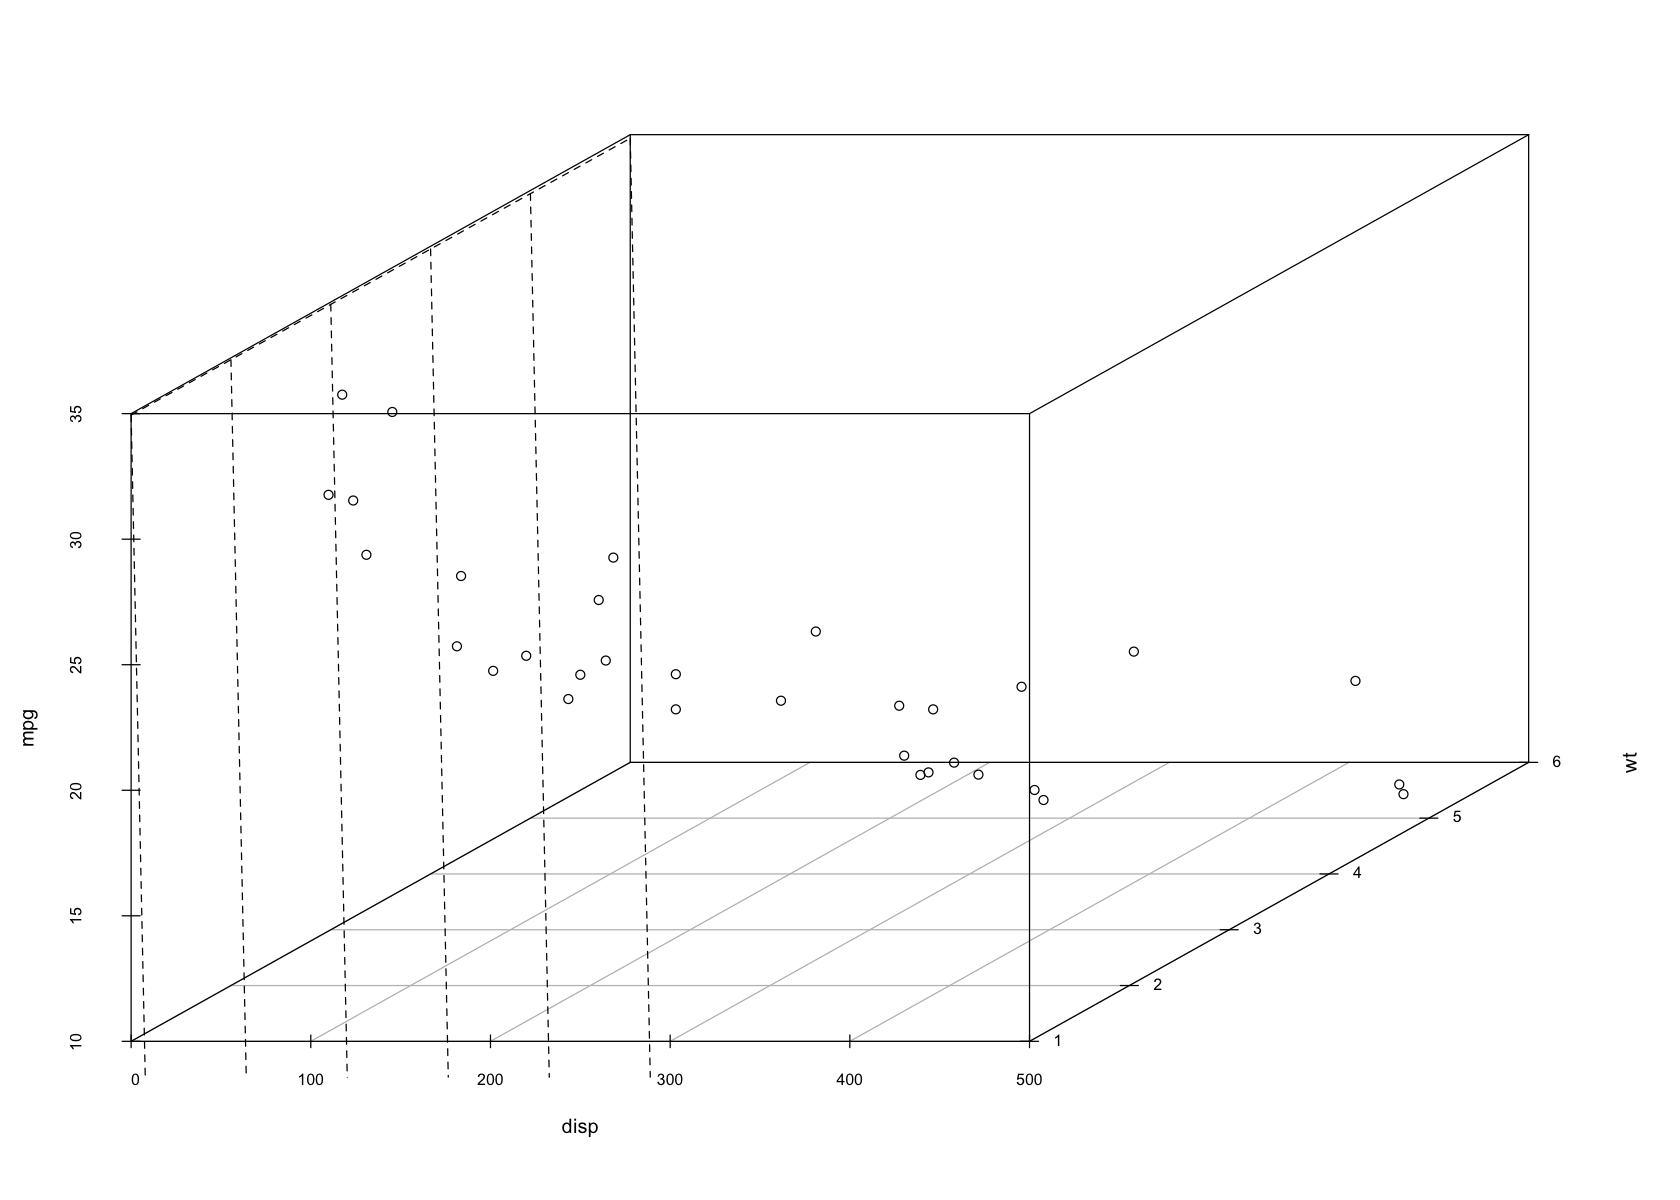

In [87]:
x <- scatterplot3d(mtcars[c('disp', 'wt', 'mpg')])

x$plane3d(lm(mtcars$mpg ~ mtcars$wt + mtcars$disp))

x$points3d(seq(10, 20, 2), seq(85, 60, -5), seq(60, 10, -10),
    col = "red", type = "h", pch = 8)

### Question 3.3 - Resampling 
From these results, I would say Model 3 performed the best because even though it doesn't have the lowest MAE, it has the second lowest RMSE and highest Adjusted R-Squared value. This means that the predictors of Model 3 explained almost 95% of the data. However, this model may have the best performance, but that doesn't mandate it to be the best model for scenario. 

In [522]:
mycontrol = trainControl(method = "CV",number=10,)

model1 = train(mpg~ poly(disp,2, raw = TRUE),
               data = mtcars,
               method = "lm",
               trControl=mycontrol)

model2 = train(mpg~ poly(wt,2, raw = TRUE),
               data = mtcars,
               method = "lm",
               trControl=mycontrol)

model3 = train(mpg~ wt*as.factor(cyl) + disp*as.factor(cyl),
               data = mtcars,
               method = "lm",
               trControl=mycontrol)

summary(resamples(list(model1,model2,model3)))


Call:
summary.resamples(object = resamples(list(model1, model2, model3)))

Models: Model1, Model2, Model3 
Number of resamples: 10 

MAE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
Model1 1.208919 1.830611 2.052675 2.395649 2.908546 4.694559    0
Model2 1.049385 1.756802 2.294716 2.308569 2.672313 4.133860    0
Model3 1.101407 1.669240 2.333481 2.417833 2.924918 4.295347    0

RMSE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
Model1 1.211494 2.216246 2.680918 2.835867 3.424428 4.947705    0
Model2 1.061038 2.014951 2.431441 2.592520 3.112642 4.271902    0
Model3 1.249404 1.815206 2.525714 2.643766 3.212123 4.337436    0

Rsquared 
            Min.   1st Qu.    Median      Mean   3rd Qu. Max. NA's
Model1 0.4985666 0.7056600 0.8522621 0.8183717 0.9656786    1    0
Model2 0.5850876 0.7458816 0.8703651 0.8483684 0.9767225    1    0
Model3 0.8080199 0.9314099 0.9558738 0.9474830 0.9902352    1    0


### Question 3.4 - Winner Winner
Personally, I would choose Model with Weight as a quadractic term. Though, Model 3 has a better performance, it lacks the interpretability of Model 2. Model 2 simply takes the square of the weight and regresses it on mpg, but Model 3 is a mulltidimensional model with cyl interacting with both disp and wt. Similarly, Model 2 has an adjusted R-Squared of 0.8484 and RMSE of 2.6437; the loss in performance is not so significant that the model with yield relatively worst results. Model 1 I would not use entirely because visually, it fits the data the worst of all models, where as Model 2 and 3 have better fits that are closer to each other. 

## Question 4 - Step by Step, Branch by Branch

In [765]:
step_loss <- function(x, y, c1) {
loss <- var(y[x < c1]) + var(y[x >= c1])
return(loss)
}

step_minimizer <- function(x, y) {
c1 <- optim(c(c1 = median(x)), fn = step_loss, x = x, y = y,
method = "Brent", lower = min(x), upper = max(x))
return(c1$par)
}

step_comparitor <- function(x, y, c1, level) {
# Compare the p-value from a t-test to the `level` argument
do_split <- t.test(y[x < c1], y[x >= c1])$p.value <= level
return(do_split)
}

find_knots <- function(x, y, level = 0.05, minsize = 10) {
    # Recursively traverse either side of each knot,
    # recording all knots as it goes.
    if (length(x) < minsize) {
        return(numeric(0)) # Don't split (stop)
    }
    c1 <- step_minimizer(x, y)
    do_first_split <- step_comparitor(x, y, c1, level)
    if (do_first_split) {
        left_split <- find_knots(x[x < c1], y[x < c1],
            level = level)
        right_split <- find_knots(x[x >= c1], y[x >= c1],
            level = level)
        splits <- sort(c(c1, left_split, right_split))
        return(splits)
    } else {
        return(numeric(0)) # Don't split (stop)
    } 
}

Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”
Warning message in optimize(function(par) fn(par, ...)/con$fnscale, lower = lower, :
“NA/Inf replaced by maximum positive value”


[1] 2.050768 5.849372


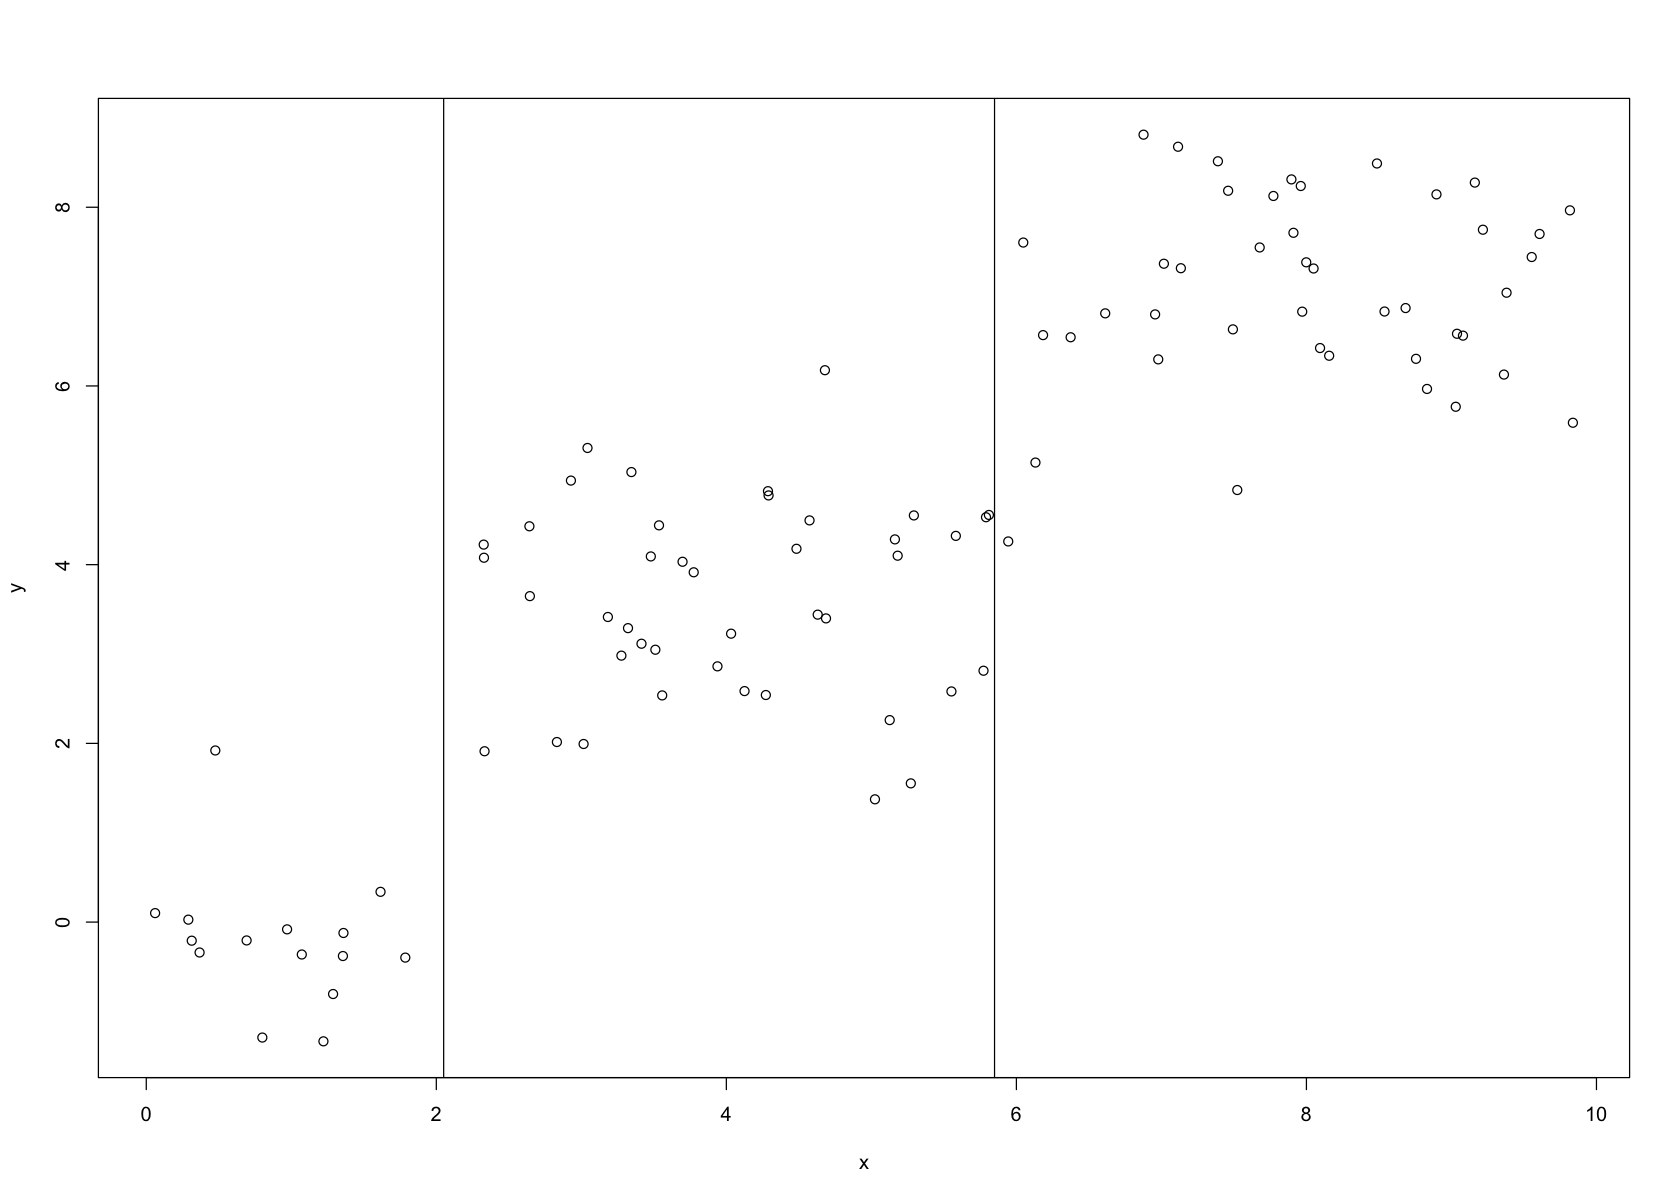

In [762]:
x <- runif(n = 100, 0, 10)
knots <- c(2, 6)
g <- cut(x, c(-Inf, knots, Inf), labels = FALSE)
y <- rnorm(length(x), mean = c(0, 4, 7)[g], sd = 1)
estimated_knots <- find_knots(x, y, level = 0.05)
print(estimated_knots)
plot(x, y)
abline(v = estimated_knots)

[1] 7.683960 8.825028 9.583649


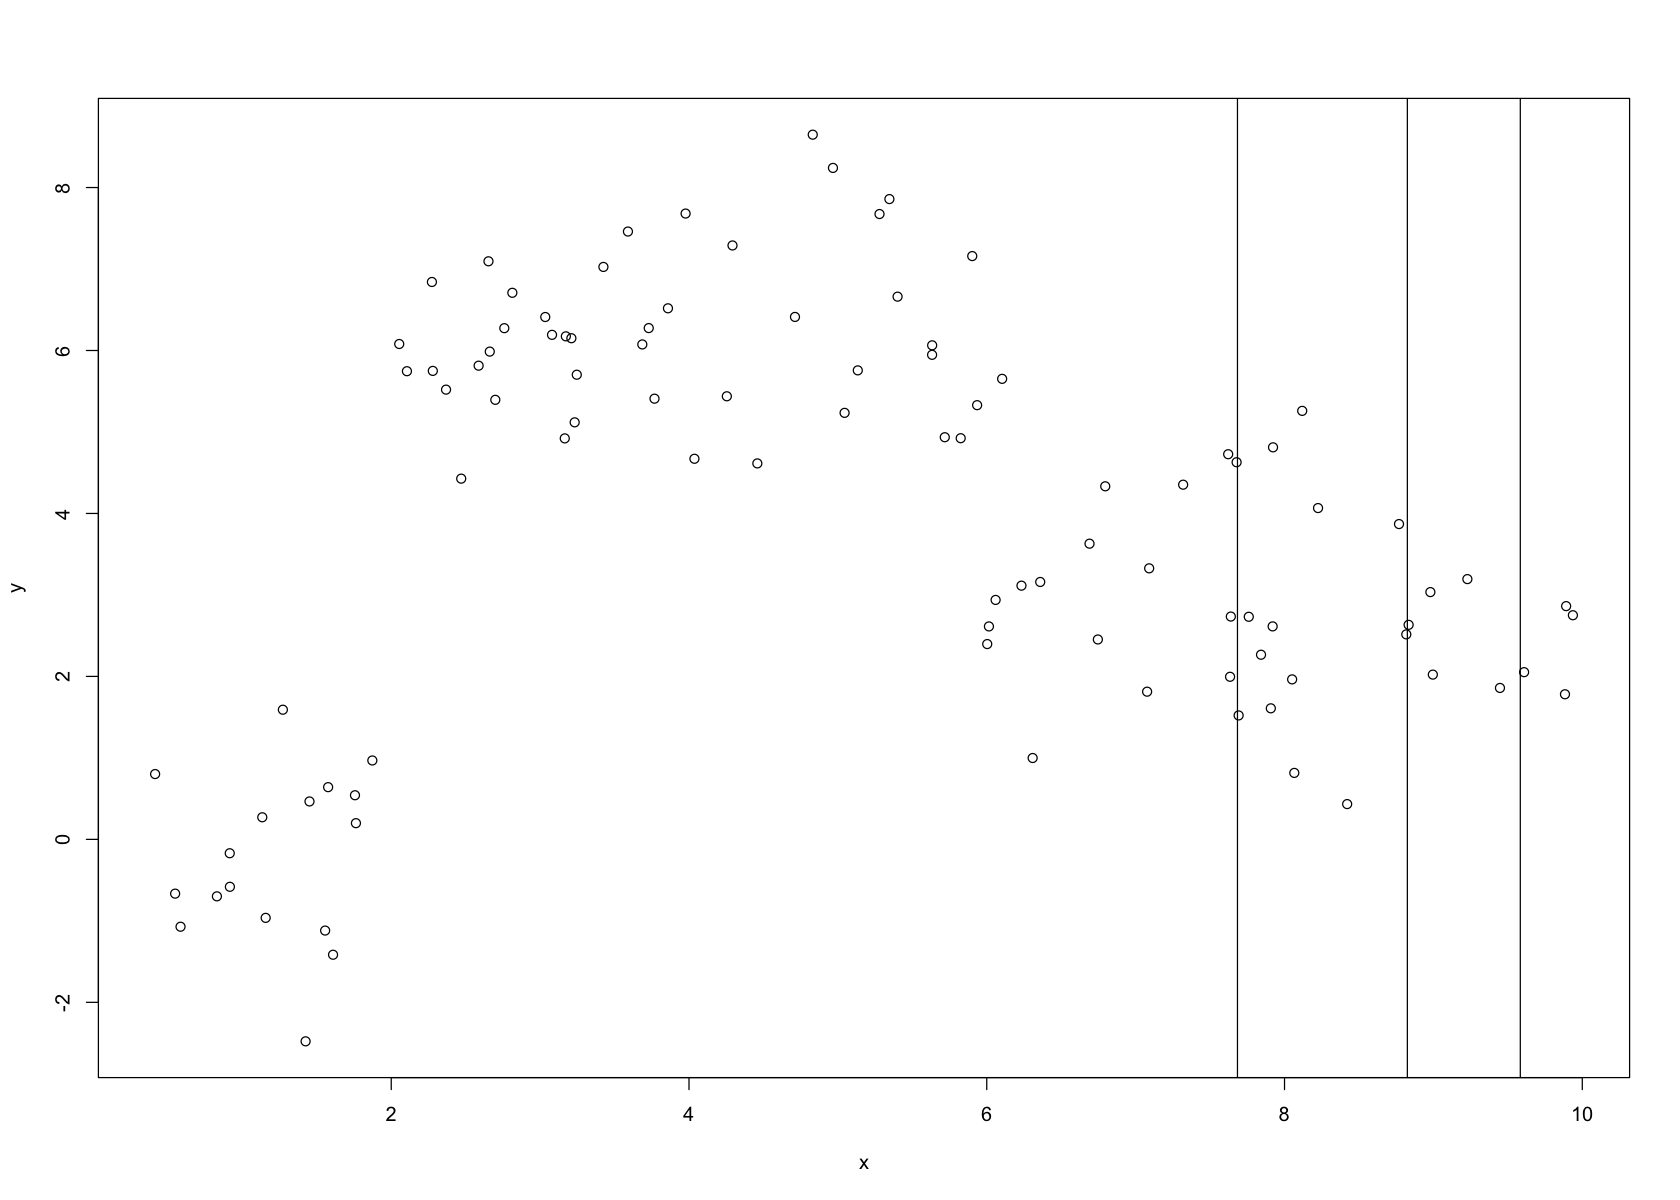

In [788]:
x <- runif(n = 100, 0, 10)
knots <- c(2, 6)
g <- cut(x, c(-Inf, knots, Inf), labels = FALSE)
y <- rnorm(length(x), mean = c(0, 6, 3)[g], sd = 1)
estimated_knots <- find_knots(x, y, level = 0.05)
print(estimated_knots)
plot(x, y)
abline(v = estimated_knots)

#### Question 4.1
Based on the simulations, the assumption this model follow are:
- knots $\in$ [2,6] 
- the mean only assumes 0, 4, 7, while the standard deviation is constant
- the points location of the points remain relatively the same for each region

#### Question 4.2
I believe the step loss is appropriate for this purpose because the step loss function searches for a knot such that the sum of the variance on both sides of the knot is ideal. The function doesn't seek to minimize the variance completely, but searches for a balance between the variances on both sides of the knot like a fulcrum. 

#### Question 4.3
I noticed that the model has issues finding the optimal knots. Most of the time, the model can not find an optimum knots. This is because of the large jump in step size from the first cluster to the second cluster of data. This change in jump height increases the variance, which causes the T-test to fail and consequently, a knotless plot. 

#### Question 4.4
The two stopping criteria are:
- whenever the amount of knots on one side of the data is less than the minsize.
- whenever the t-test failed

Firstly, this is appropriate for this data generating process because the step heights are gradualy increasing and not so extreme. 
However, for data generating processes where the jump height is prone to large step height changes, the second stopping criteria is likely to fail.

#### Question 4.5
The tunning parameters are level and minsize variables. These can be choosen using expert judgement. If the researcher knows the behavior of the data at endpoints, they may adjust these parameters manually to control for them. Similarly, the levels can be modified to allow some points over. For exmple, $\alpha$ -> $\alpha(1-k)$, where k is a constant to control how many points to allow over the boundary.

#### Question 4.6
Adding a term that penalizies these discountinuities to this algorithm might resolve the issue. This new term forces the model toward smoother fits and the amount of which is subject to a tunning parameter. This parameter can be estimated to allow an estimation of the fit with jump continuities. However, though the tuning parameter has the capacity to penalize these discontinuities, it may not always. A simpler extension instead of penalizing the discontinuities is to allow for those discontinuities by adding basis functions where the knots are estimated. Consequently, you have defined 1st and 2nd derivatives at those jumps. 